# Classer des images à l'aide d'algorithmes de Deep Learning

Nous sommes bénévoles pour l'association de protection des animaux de notre quartier. C'est d'ailleurs ainsi que nous avons trouvé notre compagnon idéal, Snooky. Nous nous demandons donc ce que nous pourrions faire en retour pour aider l'association.</br>
Nous apprenons, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.</br>
Nous proposons de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.</br>
Les bénévoles de l'association n'ayant pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs nous utiliserons la bas de données: [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)


# **Sommaire**

*   **Partie 1:** <a href="#C1">Importation des données</a>
*   **Partie 2:** <a href="#C2">Exploration des données</a>
*   **Partie 3:** <a href="#C3">Pré-processing des images</a>
    * <a href="#C4">Réduction de la taille des images</a>
    * <a href="#C5">Passage en Noir et Blanc</a>
    * <a href="#C6">Exposition</a>
    * <a href="#C7">Contraste</a>
    * <a href="#C8">Réduction du bruit</a>
    * <a href="#C9">Whitening</a>
    * <a href="#C10">Data Augmentation</a>
*   **Partie 4:** <a href="#C11">Classification d'images avec SIFT</a>
    * <a href="#C12">Détection de Features</a>
    * <a href="#C13">Création des visual words</a>
    * <a href="#C14">Construction des bag of features</a>
    * <a href="#C15">Classification d'images</a>
*   **Partie 5:** <a href="#C16">Construction d'un réseau CNN</a>
    * <a href="#C17">Fonction d'activation</a>
    * <a href="#C18">Fonction d'optimisation</a>
    * <a href="#C19">Epochs</a>
    * <a href="#C20">Classification d'images</a>
*   **Partie 6:** <a href="#C21">CNN et transfer learning</a>
    * <a href="#C22">Fine-tuning total</a>
    * <a href="#C23">Extraction de features</a>
    * <a href="#C24">Fine-tuning partiel</a>
    * <a href="#C25">Apports de la Data Augmentation</a>

# <a name="C1">Partie 1: Imporation des données</a>
Commençons par importer les librairies utiles pour l'importation, le nettoyage et l'exploration des données.

In [ ]:
pip uninstall opencv-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.6 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import cv2 
import timeit

from PIL import Image
from matplotlib.image import imread
from wordcloud import WordCloud
from skimage.transform import resize
from skimage import img_as_ubyte, exposure, color, restoration
from skimage.io import imsave
from keras.preprocessing import image
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras import Model

Nous avons à faire à une base de données d'images. On va avoir besoin de récupérer l'adresse de chaque photo, ainsi que son étiquette, c'est-à-dire la race du chien présent sur la photo.

In [ ]:
#On récupère les uri de chaque image
dogs_lst = []
for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/Images/*/*.jpg'):
    dogs_lst.append(file)

#On les stocke dans un dataframe
data = pd.DataFrame(dogs_lst, columns=['uri'])

#On récupère les noms de fichiers
data['filename'] = data['uri'].apply(lambda x: x.split('/')[-1])

#On récupère la race du chien
data['breed'] = data['uri'].apply(lambda x: x.split('/')[-2].split('-')[-1])

#On récupère le format de la photo
data['shape'] = data['uri'].apply(lambda x: imread(x).shape)

#Hauteur de la photo
data['height'] = data['shape'].apply(lambda x: x[0])

#Largeur de la photo
data['width'] = data['shape'].apply(lambda x: x[1])

#Format de couleur utilisé
data['color'] = data['shape'].apply(lambda x: x[2])

#On récupère le ratio de la taille de l'image
data['ratio'] = data['height'] / data['width']

data.head()

uri            filename  \
0  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1065.jpg   
1  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_105.jpg   
2  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1145.jpg   
3  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1180.jpg   
4  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_108.jpg   

               breed          shape  height  width  color     ratio  
0  Brabancon_griffon  (375, 500, 3)     375    500      3  0.750000  
1  Brabancon_griffon  (480, 533, 3)     480    533      3  0.900563  
2  Brabancon_griffon  (206, 275, 3)     206    275      3  0.749091  
3  Brabancon_griffon  (170, 170, 3)     170    170      3  1.000000  
4  Brabancon_griffon  (356, 267, 3)     356    267      3  1.333333

On peut à présent sauvegarder le dataframe obtenu pour ne pas avoir à refaire toutes les étapes de prétraitement.

In [ ]:
#Exportation du jeu de donées
data.to_csv('data.csv', sep = ',', encoding='utf-8')

In [ ]:
#Chargement du jeu de données
data =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/data.csv', sep=',',encoding='utf-8')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

uri            filename  \
0  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1065.jpg   
1  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_105.jpg   
2  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1145.jpg   
3  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1180.jpg   
4  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_108.jpg   

               breed          shape  height  width  color     ratio  
0  Brabancon_griffon  (375, 500, 3)     375    500      3  0.750000  
1  Brabancon_griffon  (480, 533, 3)     480    533      3  0.900563  
2  Brabancon_griffon  (206, 275, 3)     206    275      3  0.749091  
3  Brabancon_griffon  (170, 170, 3)     170    170      3  1.000000  
4  Brabancon_griffon  (356, 267, 3)     356    267      3  1.333333

# <a name="C2">Partie 2: Exploration des données</a>

Commençons par une brève exploration des données, et vérifions si notre jeu de données ne comporte pas de valeurs manquantes.

In [ ]:
data.isnull().sum()

uri         0
filename    0
breed       0
shape       0
height      0
width       0
color       0
ratio       0
dtype: int64

In [ ]:
nb_pictures = len(data)
nb_breeds = len(data['breed'].unique())
print(f"Le jeu de données comporte {nb_pictures} photos de chiens, représentant {nb_breeds} races différentes")

Le jeu de données comporte 20580 photos de chiens, représentant 119 races différentes


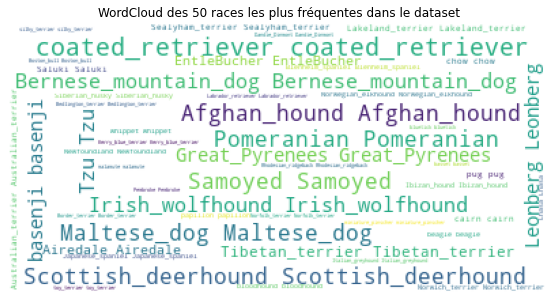

In [ ]:
#On récupère toutes les races en un seul texte pour faire un wordcloud
texte = ''
for breed in data['breed']:
  texte += breed
  texte += ' '

plt.figure(figsize=(15,5))
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud des 50 races les plus fréquentes dans le dataset')
plt.show()

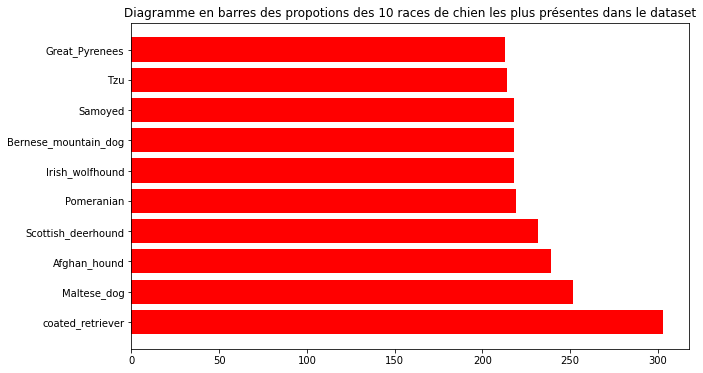

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(y=data['breed'].value_counts().index[:10], width=data['breed'].value_counts()[:10], color='red')
plt.title('Diagramme en barres des propotions des 10 races de chien les plus présentes dans le dataset')
plt.show()

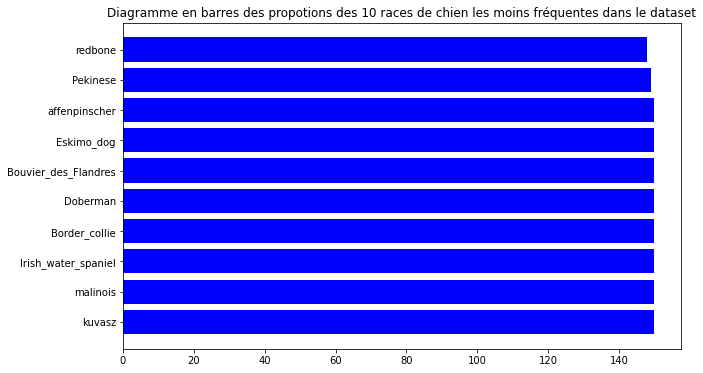

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(y=data['breed'].value_counts().index[-10:], width=data['breed'].value_counts()[-10:], color='blue')
plt.title('Diagramme en barres des propotions des 10 races de chien les moins fréquentes dans le dataset')
plt.show()

On a globalement la même proportion d'images pour chaque race de chien ce qui devrait pouvoir limiter le sur-apprentissage des modèles de prédiction par la suite.

In [ ]:
data['shape'].value_counts()

(375, 500, 3)    5301
(333, 500, 3)    2098
(500, 375, 3)    1225
(500, 333, 3)     706
(334, 500, 3)     356
                 ... 
(235, 200, 3)       1
(203, 270, 3)       1
(230, 297, 3)       1
(467, 701, 3)       1
(390, 320, 3)       1
Name: shape, Length: 4543, dtype: int64

Text(0.5, 0.98, 'Répartition des hauteurs et largeurs des photos')

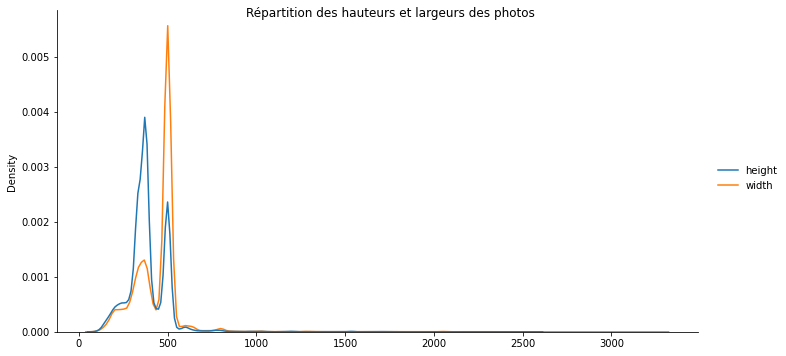

In [ ]:
graph = sns.displot(data[['height', 'width']], kind='kde', aspect=2, height=5)
graph.fig.suptitle('Répartition des hauteurs et largeurs des photos')

Un potentiel problème pour la suite est que les images n'ont pas toutes le même format. 

In [ ]:
data['color'].value_counts()

3    20579
4        1
Name: color, dtype: int64

Nous avons une image qui possède une couche alpha en plus du RGB. Nous allons la retirer car elle est théoriquement incompatible avec le format .jpg.

In [ ]:
#Fonction de récupération d'une image
def uri_to_img(uri):
  """Fonction qui prend en entrée l'adresse d'une image et renvoie l'image"""
  return imread(uri)

In [ ]:
#Fonction de visualisation de l'image
def show_image(img, title='Image', cmap_type='gray'):
  """Fonction qui prend en entrée une image et l'affiche à l'écran"""

  plt.figure(figsize=(10,6))
  plt.imshow(img, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

In [ ]:
#Fonction d'affichage de deux images côte-à-côte pour la comparaison
def comparison_2_images(img1, img2, title1='Image 1', title2='Image 2'):
  """Fonction qui prend en entrée deux images et les affiche côte-à-côte"""

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 12))

  ax1.imshow(img1, cmap='gray')
  ax1.set_title(title1)
  ax1.axis('off')

  ax2.imshow(img2, cmap='gray')
  ax2.set_title(title2)
  ax2.axis('off')

  plt.show()

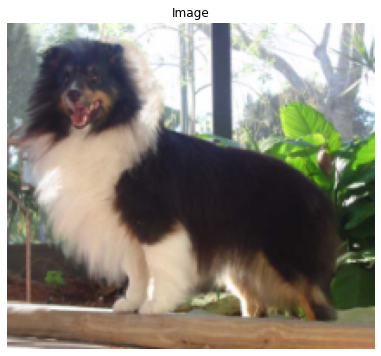

In [ ]:
idx = data[data['color']==4].index[0]
uri = data.loc[idx, 'uri']
img = uri_to_img(uri)

#Visulaisation de l'image
show_image(img)

In [ ]:
data.drop(data.index[idx], axis=0, inplace=True)
data['color'].value_counts()

3    20579
Name: color, dtype: int64

In [ ]:
#On réinitialise l'indexation
data.reset_index(drop=True, inplace=True)

# <a name="C3">Partie 3: Pré-processing des images</a>

Dans cette partie, nous allons tester différentes techniques de traitement d'image qui pourront nous servir par la suite pour nos modèles de prédiction.

## <a name="C4">3.1: Réduction de la taille des images</a>
Réduire la taille des photos va permettre de réduire leurs poids, et ainsi économiser en temps de calcul. Il faut cependant trouver une réduction qui n'altère pas trop la qualité de l'image.

In [ ]:
def resize_w220(img, ratio):
  """Fonction qui prend en entrée l'adresse d'une image ainsi que le ratio de la taille de l'image et renvoie une réduction proportionelle
  de cette image avec une largeur fixée de 220 pixels"""
  width = 220
  height = round(width * ratio, 0)

  return resize(img, (height, width), anti_aliasing=True)

In [ ]:
uri = data['uri'][0]
ratio = data['ratio'][0]
img = uri_to_img(uri)
img_reduced = resize_w220(img, ratio)

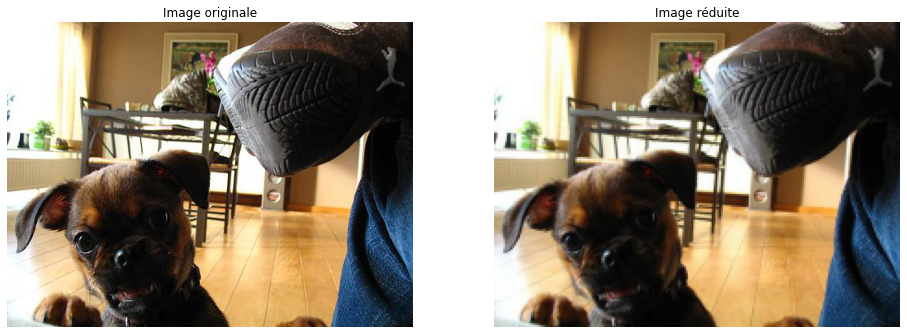

In [ ]:
comparison_2_images(img, img_reduced, 'Image originale', 'Image réduite')

In [ ]:
img_reduced.shape

(165, 220, 3)

On note une diminution de la qualité de l'image mais cette dernière demeure toutefois largement suffisante pour la détection de features. On fait donc le choix de réduire la taille pour toutes les images de notre dataset.

In [ ]:
#Création d'un dossier de stockage des images réduites
os.mkdir('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/Images_reduced')

In [ ]:
#Création de sous-dossiers pour chaque race de chien
breeds = data['breed'].unique()

for breed in breeds:
  path = '/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/Images_reduced/' + breed
  os.mkdir(path)

In [ ]:
#Nouveau dataframe mis à jour
data_reduced = data.copy()

#On réduit la taille de chaque image, on sauvegarde la nouvelle image et on met ses données à jour
path = '/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/Images_reduced/'

for i in range(len(data_reduced)):
  #Redimensionnage
  uri = data_reduced['uri'][i]
  ratio = data_reduced['ratio'][i]
  img = uri_to_img(uri)
  img_reduced = resize_w220(img, ratio)

  #Sauvegarde
  unique_path = path + data_reduced['breed'][i] + '/' + data_reduced['filename'][i]
  imsave(unique_path, img_as_ubyte(img_reduced))

  #Mise à jour des données
  data_reduced.loc[i, 'uri'] = unique_path
  data_reduced.loc[i, 'shape'] = str(img_reduced.shape)
  data_reduced.loc[i, 'height'] = img_reduced.shape[0]
  data_reduced.loc[i, 'width'] = img_reduced.shape[1]

data_reduced.head()

uri            filename  \
0  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1065.jpg   
1  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_105.jpg   
2  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1145.jpg   
3  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1180.jpg   
4  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_108.jpg   

               breed          shape  height  width  color     ratio  
0  Brabancon_griffon  (165, 220, 3)     165    220      3  0.750000  
1  Brabancon_griffon  (198, 220, 3)     198    220      3  0.900563  
2  Brabancon_griffon  (165, 220, 3)     165    220      3  0.749091  
3  Brabancon_griffon  (220, 220, 3)     220    220      3  1.000000  
4  Brabancon_griffon  (293, 220, 3)     293    220      3  1.333333

In [ ]:
#Exportation du jeu de donées
data_reduced.to_csv('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/data_reduced.csv', sep = ',', encoding='utf-8')

In [ ]:
#Chargement du jeu de données
data_reduced =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/data_reduced.csv', sep=',',encoding='utf-8')
data_reduced.drop('Unnamed: 0', axis=1, inplace=True)
data_reduced.head()

uri            filename  \
0  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1065.jpg   
1  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_105.jpg   
2  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1145.jpg   
3  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1180.jpg   
4  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_108.jpg   

               breed          shape  height  width  color     ratio  
0  Brabancon_griffon  (165, 220, 3)     165    220      3  0.750000  
1  Brabancon_griffon  (198, 220, 3)     198    220      3  0.900563  
2  Brabancon_griffon  (165, 220, 3)     165    220      3  0.749091  
3  Brabancon_griffon  (220, 220, 3)     220    220      3  1.000000  
4  Brabancon_griffon  (293, 220, 3)     293    220      3  1.333333

In [ ]:
data_reduced.isnull().sum()

uri         0
filename    0
breed       0
shape       0
height      0
width       0
color       0
ratio       0
dtype: int64

In [ ]:
nb_pictures = len(data_reduced)
nb_breeds = len(data_reduced['breed'].unique())
print(f"Le jeu de données comporte {nb_pictures} photos de chiens, représentant {nb_breeds} races différentes")

Le jeu de données comporte 20579 photos de chiens, représentant 119 races différentes


## <a name="C5">3.2: Passage en Noir et Blanc</a>

Les algorithmes utilisés pour le traitement des images fonctionnent majoritairement avec des images en noir et blanc. On va donc transformer nos images couleurs en images noires et blanches.

In [ ]:
uri = data_reduced['uri'][1000]
img = uri_to_img(uri)
gray_img = color.rgb2gray(img)

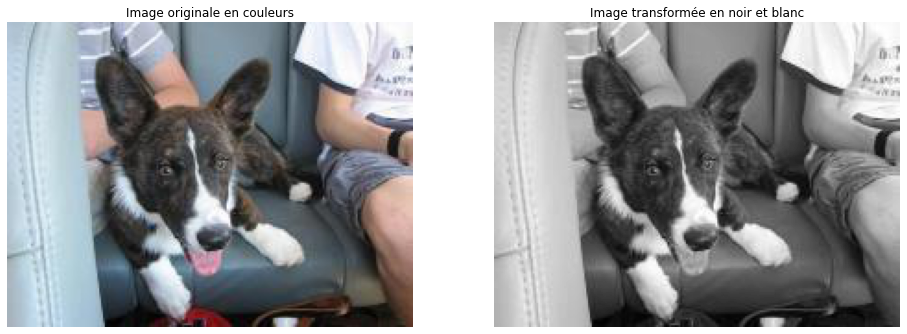

In [ ]:
comparison_2_images(img, gray_img, 'Image originale en couleurs', 'Image transformée en noir et blanc')

On peut à présent réaliser la tranformation noir et blanc sur tout notre jeu d'images.

In [ ]:
#Création d'un dossier de stockage des images réduites
os.mkdir('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/Images_grey')

In [ ]:
#Création de sous-dossiers pour chaque race de chien
breeds = data_reduced['breed'].unique()

for breed in breeds:
  path = '/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/Images_grey/' + breed
  os.mkdir(path)

In [ ]:
#Nouveau dataframe mis à jour
data_grey = data_reduced.copy()
data_grey.drop('color', axis=1, inplace=True)

#On change la couleur de chaque image, on sauvegarde la nouvelle image et on met ses données à jour
path = '/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/Images_grey/'

for i in range(len(data_grey)):
  #Redimensionnage
  uri = data_grey['uri'][i]
  img = uri_to_img(uri)
  img_grey = color.rgb2gray(img)

  #Sauvegarde
  unique_path = path + data_grey['breed'][i] + '/' + data_grey['filename'][i]
  imsave(unique_path, img_as_ubyte(img_grey))

  #Mise à jour des données
  data_grey.loc[i, 'uri'] = unique_path
  data_grey.loc[i, 'shape'] = str(img_grey.shape)

data_grey.head()

uri            filename  \
0  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1065.jpg   
1  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_105.jpg   
2  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1145.jpg   
3  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1180.jpg   
4  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_108.jpg   

               breed       shape  height  width     ratio  
0  Brabancon_griffon  (165, 220)     165    220  0.750000  
1  Brabancon_griffon  (198, 220)     198    220  0.900563  
2  Brabancon_griffon  (165, 220)     165    220  0.749091  
3  Brabancon_griffon  (220, 220)     220    220  1.000000  
4  Brabancon_griffon  (293, 220)     293    220  1.333333

In [ ]:
#Exportation du jeu de donées
data_grey.to_csv('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/data_grey.csv', sep = ',', encoding='utf-8')

In [ ]:
#Chargement du jeu de données
data_grey =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P6_BOURBON_Vicente/data_grey.csv', sep=',',encoding='utf-8')
data_grey.drop('Unnamed: 0', axis=1, inplace=True)
data_grey.head()

uri            filename  \
0  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1065.jpg   
1  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_105.jpg   
2  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1145.jpg   
3  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02112706_1180.jpg   
4  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02112706_108.jpg   

               breed       shape  height  width     ratio  
0  Brabancon_griffon  (165, 220)     165    220  0.750000  
1  Brabancon_griffon  (198, 220)     198    220  0.900563  
2  Brabancon_griffon  (165, 220)     165    220  0.749091  
3  Brabancon_griffon  (220, 220)     220    220  1.000000  
4  Brabancon_griffon  (293, 220)     293    220  1.333333

In [ ]:
nb_pictures = len(data_grey)
nb_breeds = len(data_grey['breed'].unique())
print(f"Le jeu de données comporte {nb_pictures} photos de chiens, représentant {nb_breeds} races différentes")

Le jeu de données comporte 20579 photos de chiens, représentant 119 races différentes


## <a name="C6">3.3: Exposition</a>

En considérant l'histogramme d'une image numérique, c'est-à-dire la courbe statistique représentant la répartition de ses pixels selon leur intensité, une première application consite à corriger la luminosité, ou exposition, d'une image en étirant celui-ci.</br>
Regardons cela sur un exemple.

In [ ]:
def show_histogram(img, title="Histogramme de l'image"):
  """Fonction de visualisation de l'histogramme d'une image"""

  plt.figure(figsize=(10, 6))
  img_hist, bins = exposure.histogram(img, source_range='dtype')
  plt.plot(bins, img_hist / img_hist.max())
  plt.title(title)
  plt.show()

In [ ]:
def comparison_2_histograms(img1, img2, title1='Histogramme 1', title2='Histogramme 2'):
  """Fonction qui prend en entrée deux images et affiche leurs histogrammes côte-à-côte pour pouvoir les comparer"""

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

  img_hist1, bins1 = exposure.histogram(img1, source_range='dtype')
  ax1.plot(bins1, img_hist1 / img_hist1.max())
  ax1.set_title(title1)
  
  img_hist2, bins2 = exposure.histogram(img2, source_range='dtype')
  ax2.plot(bins2, img_hist2 / img_hist2.max())
  ax2.set_title(title2)

  plt.show()

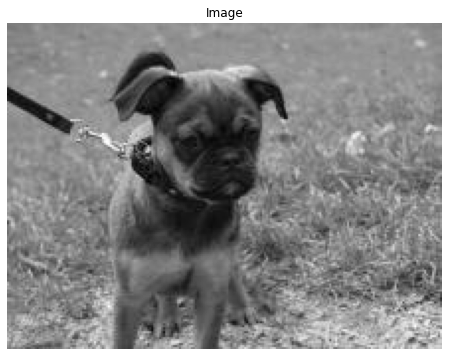

In [ ]:
uri = data_grey['uri'][89]
img = uri_to_img(uri)
show_image(img)

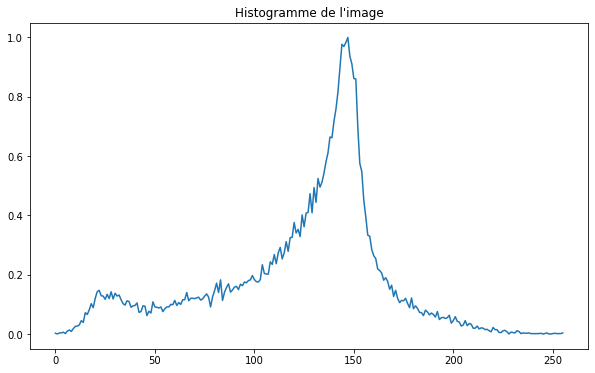

In [ ]:
show_histogram(img)

In [ ]:
exposure.is_low_contrast(img)

False

Les pixels de l'image sont répartis de façon homogène sur toute la plage des valeurs possibles, l'exposition de l'image est donc bonne. Regardons l'effet produit sur l'histogramme en assombrissant l'image.

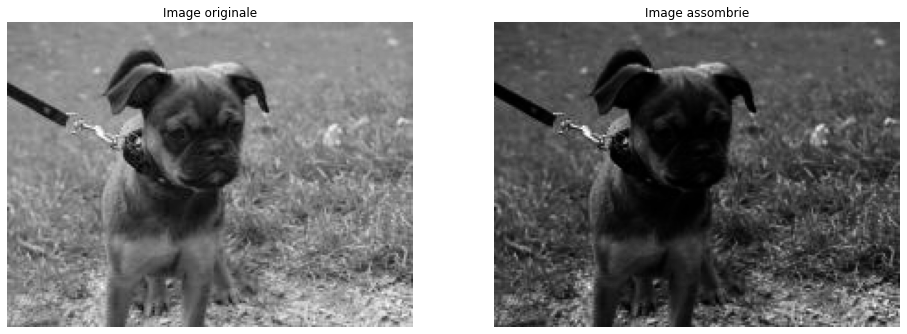

In [ ]:
img_darkened = exposure.adjust_gamma(img, gamma=2)
comparison_2_images(img, img_darkened, 'Image originale', 'Image assombrie')

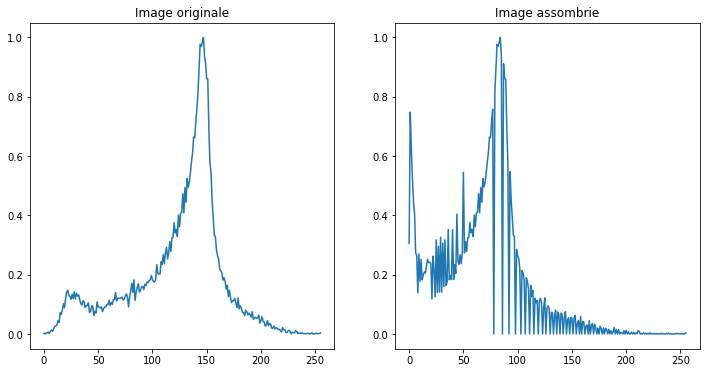

In [ ]:
comparison_2_histograms(img, img_darkened, 'Image originale', 'Image assombrie')

Les pixels se concentrent davantage dans la partie gauche.

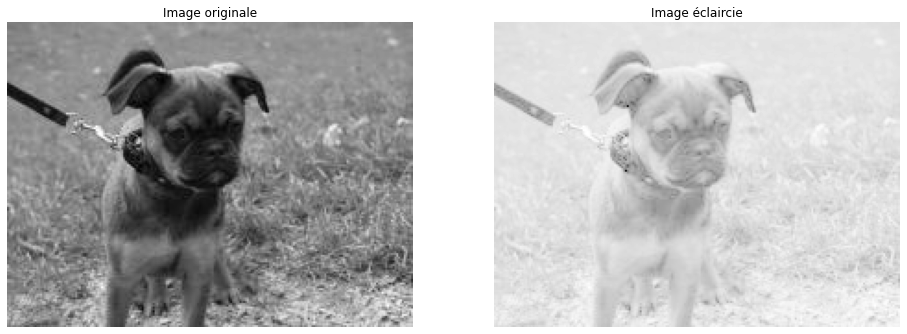

In [ ]:
img_brightened = exposure.adjust_gamma(img, gamma=0.2)
comparison_2_images(img, img_brightened, 'Image originale', 'Image éclaircie')

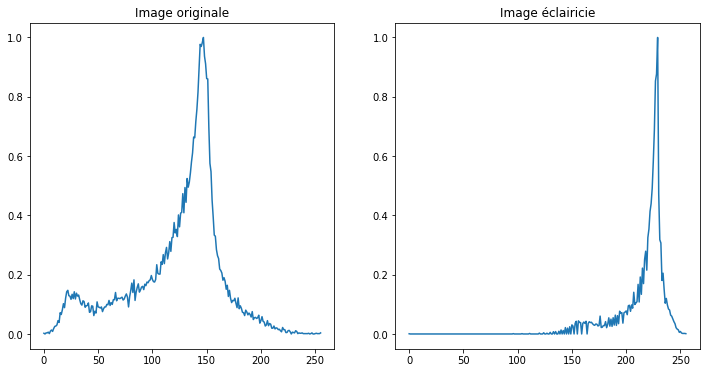

In [ ]:
comparison_2_histograms(img, img_brightened, 'Image originale', 'Image éclairicie')

Les pixels d'une image trop claire se concentrent majoritairement à droite de la plage des valeurs.

## <a name="C7">3.4: Contraste</a>

La deuxième application courante sur l'histogramme concerne l'amélioration du contraste de l'image. Le contraste caractérise la répartition de lumière dans une image : plus une image est contrastée, plus la différence de luminosité entre ses zones claires et sombres est importante.</br>
L'égalisation d'histogrammes est une technique simple permettant de réajuster le contraste d'une image et ainsi de lui redonner du peps ou de l'adoucir. 

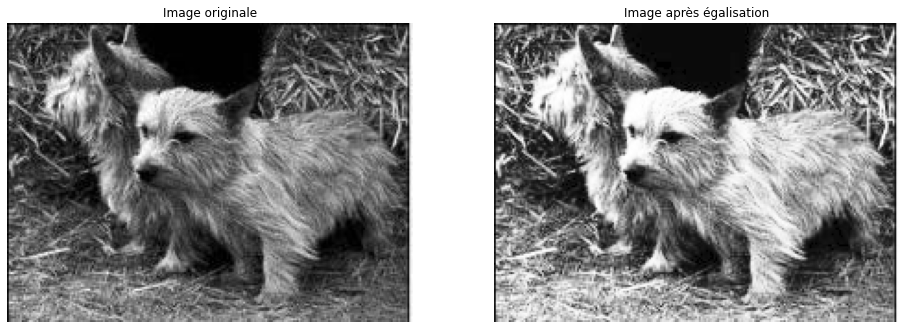

In [ ]:
uri = data_grey['uri'][15000]
img = uri_to_img(uri)
img_equalized = exposure.equalize_hist(img)

comparison_2_images(img, img_equalized, 'Image originale', 'Image après égalisation')

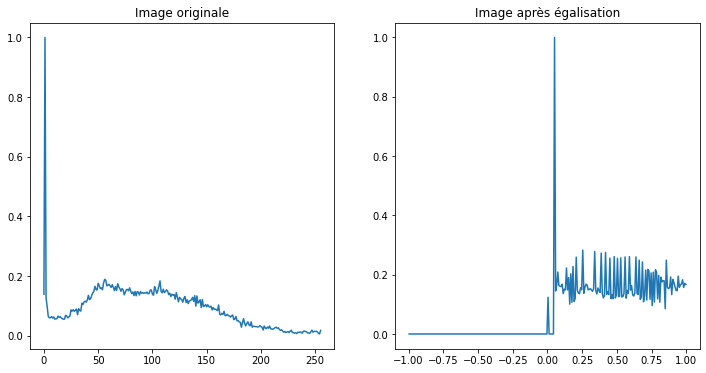

In [ ]:
comparison_2_histograms(img, img_equalized, 'Image originale', 'Image après égalisation')

## <a name="C8">3.5: Réduction du bruit</a>
La réduction du bruit d'une image correspond à l'application d'un filtre qui a pour but de transformer la valeur d'un pixel en tenant compte de la valeur des pixels voisins et ainsi réduire les éventuelles valeurs aberrantes.


Le premier filtre que l'on va tester est un filtre de réduction du bruit qui préserve les bords. Il fait la moyenne des pixels en fonction de leur proximité spatiale et de leur similarité radiométrique.

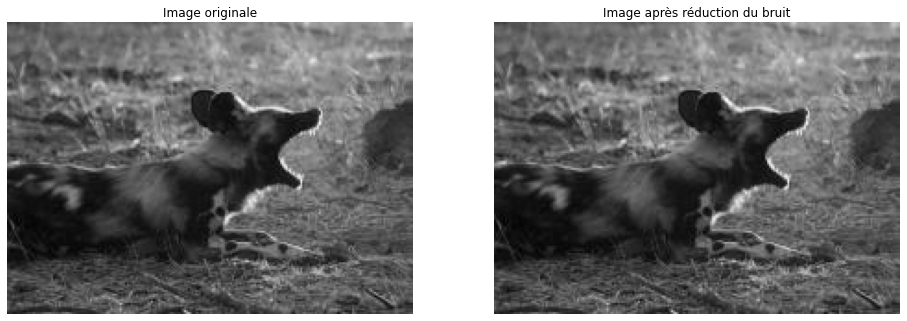

In [ ]:
uri = data_grey['uri'][500]
img = uri_to_img(uri)
img_denoised = restoration.denoise_bilateral(img)

comparison_2_images(img, img_denoised, 'Image originale', 'Image après réduction du bruit')

Le principe du second algorithme testé est de faire la moyenne de la valeur d'un pixel donné avec les valeurs des autres pixels dans un voisinage limité.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Image dtype is not float. By default denoise_nl_means will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.19 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  """Entry point for launching an IPython kernel.


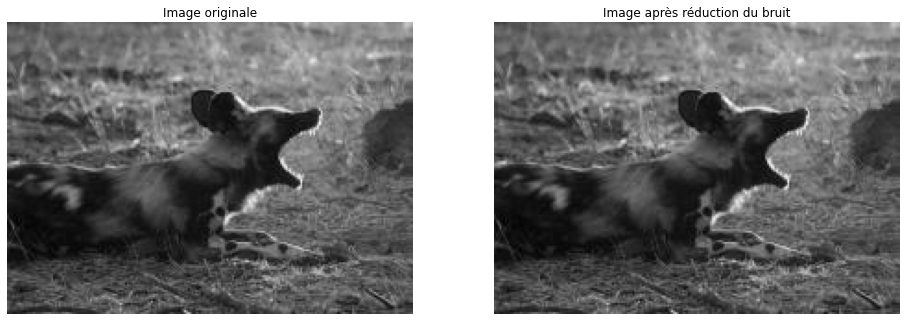

In [ ]:
img_denoised2 = restoration.denoise_nl_means(img)
comparison_2_images(img, img_denoised2, 'Image originale', 'Image après réduction du bruit')

La dernière méthode utilise le principe du débruitage à variation totale via l'optimisation de Bergman afin de minimiser la variation totale de l'image. Le débruitage par variation totale tend à produire des images de type "cartoon", c'est-à-dire des images constantes par morceaux.

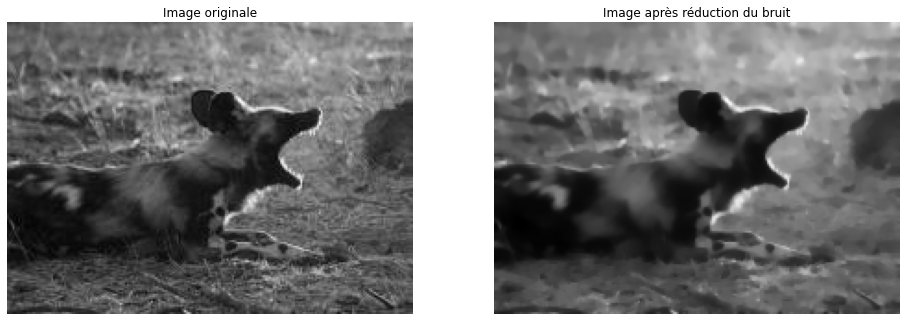

In [ ]:
img_denoised3 = restoration.denoise_tv_bregman(img, weight=10)
comparison_2_images(img, img_denoised3, 'Image originale', 'Image après réduction du bruit')

## <a name="C9">3.6: Whitening</a>

Le Whitening est une transformation linéaire qui transforme un vecteur de variables aléatoires avec une matrice de covariance connue en un ensemble de nouvelles variables non corrélées et de même variance.</br>
Dans les images, les pixels ont souvent tendance à être corrélés à leurs plus proches voisins. Appliquer la méthode de Whitening permet de supprimer ces corrélations, ce qui peut s'avérer utile pour la détection de features et l'entraînement de modèles de machine learning.

In [ ]:
def whitening(img):
  """Fonction qui prend en entrée une image et la renvoie après transformation whitening avec ZCA"""

  #On centre les données
  img_centered = img.T - np.mean(img.T, axis=0)
  img_centered = img_centered.T
 
  #On calcule la matrice de covariance
  img_cov = np.cov(img_centered, rowvar=True, bias=True)
 
  #On calcule les valeurs et vecteurs propores
  w, v = linalg.eig(img_cov)
 
  #On calcule l'inverse da la racine carrée des valeurs propres
  diagw = np.diag(1/(w**0.5))
  diagw = diagw.real.round(4)

  
  # Whitening transform using ZCA (Zero Component Analysis)
  img_whitened = np.dot(np.dot(np.dot(v, diagw), v.T), img_centered)

  return img_whitened

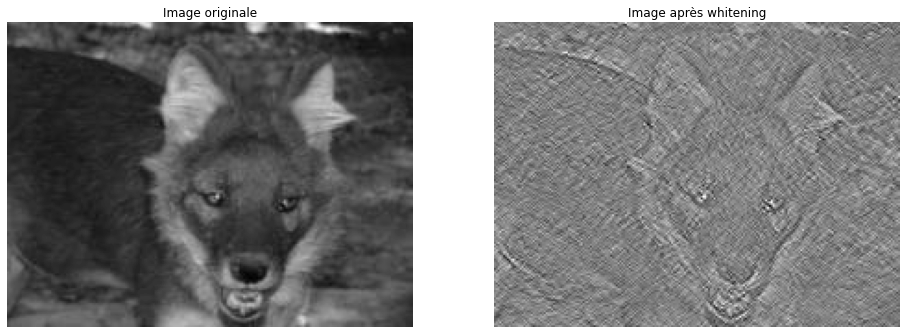

In [ ]:
uri = data_grey['uri'][300]
img = uri_to_img(uri)
img_whitened = whitening(img)

comparison_2_images(img, img_whitened, 'Image originale', 'Image après whitening')

Le whitening semble ici trop modifier l'image, ce qui pourrait être pénalisant par la suite pour la détection de features.

## <a name="C10">3.7: Data Augmentation</a>

La Data Augmentation est une technique utilisée pour accroître la quantité de données en ajoutant des copies légèrement modifiées de données existantes ou des données synthétiques nouvellement créées à partir de données existantes. Elle agit comme un régularisateur et permet de réduire l'overfitting lors de l'apprentissage d'un modèle de machine learning.

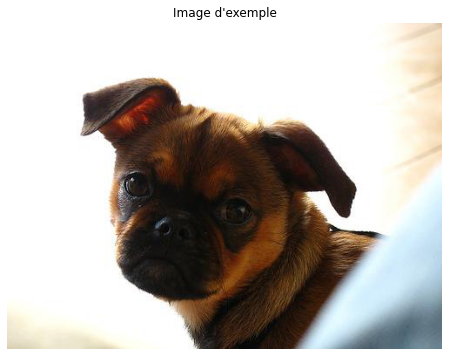

In [ ]:
uri = data['uri'][10]
img = uri_to_img(uri)
show_image(img, "Image d'exemple")

In [ ]:
datagen = image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        shear_range=0.2,
        brightness_range=[0.2,1.2], 
        fill_mode="nearest")

def data_augmentation(img, datagen):
  """Fonction qui prend en entrée une image et un modèle de data augmentation et affiche 6 nouvelles images
  générées par le modèle"""

  img = image.img_to_array(img)
  img = img.reshape((1,) + img.shape)
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))
    
  cpt = 0 
  i = 0
  j = 0
  for batch in datagen.flow(img):
    ax[i,j].imshow(image.array_to_img(batch[0]))
    ax[i,j].axis('off')
    ax[i,j].set_title('Augmentation ' + str(cpt))
    # Changement de subplot
    j += 1
    if j == 3:
      j = 0
      i = 1

    # Arrêt au bout de 6 images
    cpt+=1
    if cpt == 6 :
      break

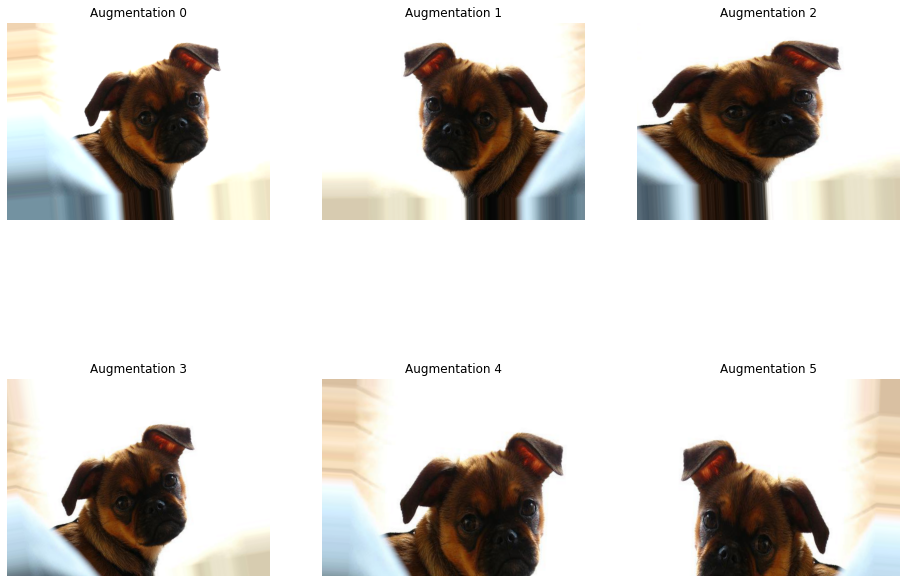

In [ ]:
data_augmentation(img, datagen)

# <a name="C11">Partie 4: Classification d'images avec SIFT</a>
L'algorithme SIFT (Scale-invariant feature transform), développé en 1999 et très populaire dans le domaine de la vision par ordinateur, permet d'extraire des features de l'image et de calculer leurs descripteurs. Il a l'avantage de détecter des features invariantes par rotation et changement d'échelle.

Dans le cadre de notre problématique, cette approche ne servira qu'à explorer et se familiariser avec le travail sur des images, notamment les processus d'extraction et de description des features qui seront par la suite complètement automatisés dans les modèles de Deep Learning.</br>
Par conséquent, on va réduire notre jeu de données aux trois races les plus fréquentes.

In [ ]:
#Liste des races les plus fréquentes
top_breeds = list(data_grey['breed'].value_counts().index[:3])
top_breeds

['coated_retriever', 'Maltese_dog', 'Afghan_hound']

In [ ]:
df = data_grey[data_grey.breed.isin(top_breeds)]
df

uri            filename  \
11076  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02099429_1150.jpg   
11077  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02099429_1178.jpg   
11078  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02099429_1234.jpg   
11079  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02099429_1039.jpg   
11080  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02099429_1236.jpg   
...                                                  ...                 ...   
20229  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02088094_988.jpg   
20230  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02088094_899.jpg   
20231  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...  n02088094_9220.jpg   
20232  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02088094_986.jpg   
20233  /content/drive/MyDrive/Colab Notebooks/P6_BOUR...   n02088094_908.jpg   

                  breed       shape  height  width     ratio  
11076  coated_retriever  (317, 220)     317    220  1.438849  
11077  coated_retriever  (179, 220)     179    220  0.814035  
11078  coated_retriever  (157, 220)     157    220  0.711429  
11079  coated_retriever  (251, 220)     251    220  1.141553  
11080  coated_retriever  (146, 220)     146    220  0.664000  
...                 ...         ...     ...    ...       ...  
20229      Afghan_hound  (244, 220)     244    220  1.110000  
20230      Afghan_hound  (149, 220)     149    220  0.678000  
20231      Afghan_hound  (217, 220)     217    220  0.988000  
20232      Afghan_hound  (330, 220)     330    220  1.501502  
20233      Afghan_hound  (255, 220)     255    220  1.157407  

[794 rows x 7 columns]

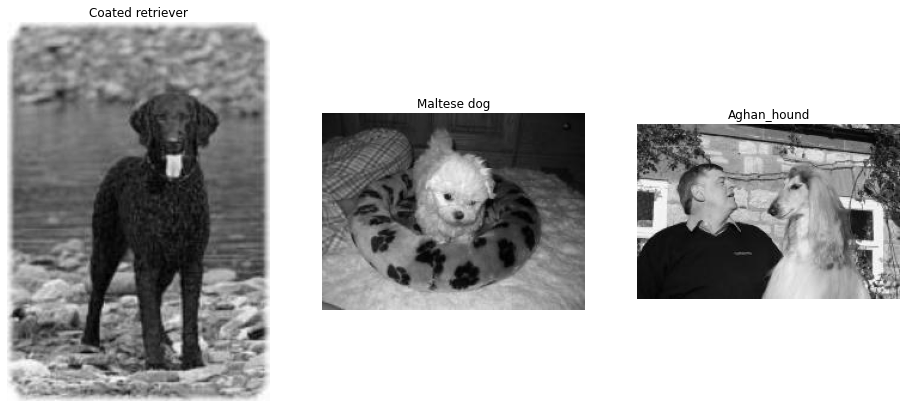

In [ ]:
uri1 = list(df[df['breed']=='coated_retriever']['uri'])[0]
img1 = uri_to_img(uri1)

uri2 = list(df[df['breed']=='Maltese_dog']['uri'])[0]
img2 = uri_to_img(uri2)

uri3 = list(df[df['breed']=='Afghan_hound']['uri'])[0]
img3 = uri_to_img(uri3)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 12))

ax1.imshow(img1, cmap='gray')
ax1.set_title('Coated retriever')
ax1.axis('off')

ax2.imshow(img2, cmap='gray')
ax2.set_title('Maltese dog')
ax2.axis('off')

ax3.imshow(img3, cmap='gray')
ax3.set_title('Aghan_hound')
ax3.axis('off')

plt.show()

In [ ]:
#Jeux d'entraînement et de test
X = df['uri']
y = df['breed'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)

## <a name="C12">4.1: Détection de Features</a>
La première étape consiste à détecter les features de l'image. Chaque feature est une zone circulaire intéressante, repérée par son centre (point d'intérêt), et dont le rayon est proportionnel à son échelle caractéristique. La force du détecteur SIFT est sa capacité à trouver des rayons différents, et donc des features de différentes tailles.

Regardons dans un premier temps un exemple de détection de features.

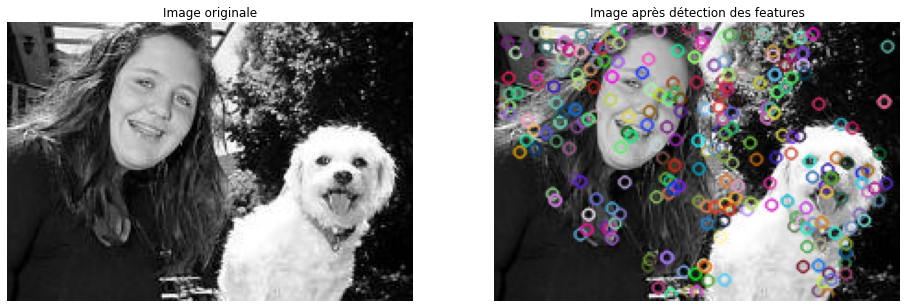

In [ ]:
uri = list(X_train)[0]
img = uri_to_img(uri)

#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img, None)
img_features = cv2.drawKeypoints(img, keypoints, img)

#Affichage
comparison_2_images(img, img_features, 'Image originale', 'Image après détection des features')

Les ronds de couleurs représentent les features qui ont été détectées par l'algorithme SIFT.</br>
On peut essayer de réduire un peu le bruit de l'image de sorte à réduire le nombre de features.

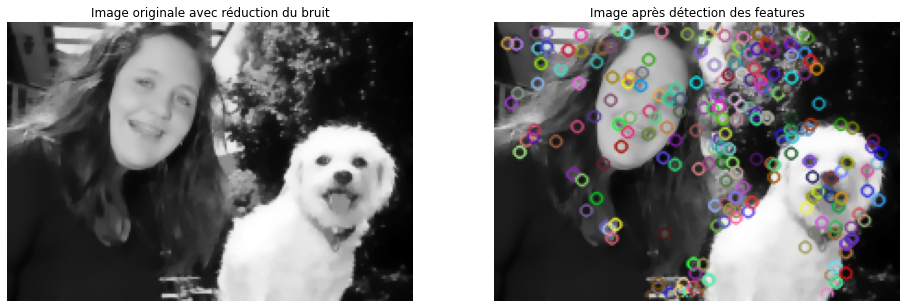

In [ ]:
#Réduction du bruit
img_denoised = restoration.denoise_tv_bregman(img, weight=10)
img_denoised = cv2.normalize(img_denoised, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

#Keypoints
keypoints, descriptors = sift.detectAndCompute(img_denoised, None)
img_features = cv2.drawKeypoints(img_denoised, keypoints, img_denoised)

#Affichage
comparison_2_images(img_denoised, img_features, 'Image originale avec réduction du bruit', 'Image après détection des features')

On va procéder à la recherche et la description des features sur le jeu d'entraînement en réduisant à chaque fois le bruit de l'image.

In [ ]:
def get_sift_descriptors(liste_uri):
  """Fonction qui prend en entrée une liste (d'adresses) d'images et renvoie la liste des descripteurs de features
  obtenus à l'aide de l'algorithme SIFT"""

  descriptors_list = []
  sift = cv2.xfeatures2d.SIFT_create()
    
  for uri in liste_uri:
    #Lecture de l'image
    img = uri_to_img(uri)
    #Réduction du bruit
    img_denoised = restoration.denoise_tv_bregman(img, weight=10)
    #Conversion en 8 bit
    img8bit = cv2.normalize(img_denoised, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    #Calcul des descripteurs
    keypoints, descriptors = sift.detectAndCompute(img8bit, None)

    descriptors_list.extend(descriptors)

  return descriptors_list

In [ ]:
%time descriptors_list = get_sift_descriptors(X_train)
print(f"Il y a {len(descriptors_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

CPU times: user 35.4 s, sys: 1.48 s, total: 36.9 s
Wall time: 2min 33s
Il y a 142592 descripteurs dans le jeu d'entrainement (635 photos)


## <a name="C13">4.2: Création des visual words</a>

L'étape précédente nous a permi d'obtenir beaucoup de features, or, certaines représentent un même élément mais de manières différentes. Ces éléments qui se déclinent en plusieurs versions sont appelés des **visual words**. Pour les trouver, il suffit d'appliquer un algorithme de clustering aux descripteurs obtenus ci-dessus.</br>
La méthode SIFT n'étant pas la méthode que l'on va développer par la suite, nous ne sommes pas trop préocuppés par la qualité de prédiction finale. Ainsi, on va utiliser un MiniBatchKmeans pour réduire le temps de calcul.

In [ ]:
batch_size = int(len(descriptors_list) * 0.2)

#Score pour la comparaison
Sum_of_squared_distances = []
#Nombre de clusters à tester
K = np.arange(100, 1000, 100)

for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    kmeans = kmeans.fit(descriptors_list)
    Sum_of_squared_distances.append(kmeans.inertia_)

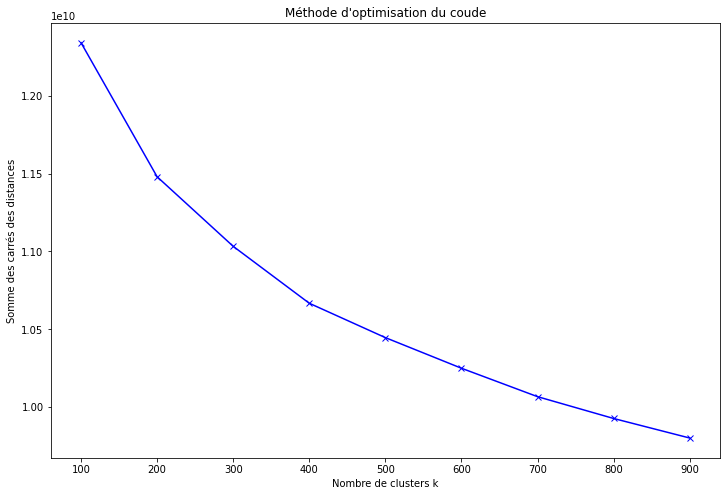

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Somme des carrés des distances')
plt.title("Méthode d'optimisation du coude")
plt.show()

On voit nettement un coude se dessiner progressivement. Choisissons donc k=500 pour notre recherche de visual words

In [ ]:
k = 500
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
%time kmeans.fit(descriptors_list)

CPU times: user 1min 44s, sys: 13.6 s, total: 1min 57s
Wall time: 1min


MiniBatchKMeans(batch_size=28518, n_clusters=500)

## <a name="C14">4.3: Construction des bag of features</a>

Il reste à décrire les images en fonction de ces visual words. Pour chaque image, on crée un histogramme qui indique la fréquence d'apparition de chaque visual word dans l'image. Le bag-of-features d'une image est le vecteur dans lequel on a stocké les valeurs de l'histogramme.

In [ ]:
def get_bof_sift(uri_list, kmeans, n_clusters):
  """Fonction qui prend en entrée un liste (d'adresses) d'images, le modèle de clustering utilisé pour la détection 
  des visual words ainsi que le nombre de clusters et renvoie le data frame des bag of features de la liste d'images"""

  matrix = A = np.zeros((len(uri_list),n_clusters))
  sift = cv2.xfeatures2d.SIFT_create()
  for i in range(len(uri_list)):
    #Lecture de l'image
    img = uri_to_img(uri_list[i])
    #Réduction du bruit
    img_denoised = restoration.denoise_tv_bregman(img, weight=10)
    #Conversion en 8 bit
    img8bit = cv2.normalize(img_denoised, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    #Calcul des descripteurs
    keypoints, descriptors = sift.detectAndCompute(img8bit, None)

    label = pd.Series(kmeans.predict(descriptors.astype('float'))).value_counts()
    index = label.index
    for j in index:
      matrix[i, j] = label[j]
    df = pd.DataFrame(matrix)

  return df

In [ ]:
bof_train = get_bof_sift(list(X_train), kmeans, k)
bof_train.head()

0    1    2    3    4    5    6    7    8    9    ...  490  491  492  493  \
0  1.0  0.0  0.0  0.0  2.0  1.0  0.0  2.0  0.0  0.0  ...  1.0  0.0  0.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  1.0  3.0  0.0  3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  2.0  0.0   
3  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   494  495  496  497  498  499  
0  0.0  0.0  2.0  0.0  1.0  0.0  
1  0.0  1.0  0.0  1.0  0.0  0.0  
2  1.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  1.0  2.0  0.0  0.0  0.0  1.0  

[5 rows x 500 columns]

In [ ]:
bof_test = get_bof_sift(list(X_test), kmeans, k)
bof_test.head()

0    1    2    3    4    5    6    7    8    9    ...  490  491  492  493  \
0  0.0  0.0  0.0  1.0  0.0  1.0  2.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  2.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
4  2.0  0.0  1.0  0.0  3.0  1.0  0.0  3.0  0.0  2.0  ...  3.0  1.0  0.0  2.0   

   494  495  496  497  498  499  
0  0.0  1.0  0.0  0.0  1.0  0.0  
1  0.0  0.0  0.0  0.0  1.0  0.0  
2  1.0  1.0  0.0  0.0  0.0  0.0  
3  0.0  1.0  0.0  0.0  1.0  0.0  
4  1.0  0.0  2.0  0.0  0.0  2.0  

[5 rows x 500 columns]

## <a name="C15">4.4: Classification d'images</a>

Maintenant que toutes nos images sont représentées par des bag of features ont peut entrainer un modèle de classification afin de prédire la race d'un chien. Pour cela, on va utiliser une méthode SVC multi-classes.

In [ ]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [00.1, 0.1, 1]}

lsvc = LinearSVC()
model = GridSearchCV(lsvc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(bof_train, y_train)

print(" Best parameters: " + str(model.best_params_))
print("Best accuracy score = " +str(model.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/usr/loca

 Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best accuracy score = 0.6456692913385826


In [ ]:
final_model = model.best_estimator_
final_model.fit(bof_train, y_train)
y_pred = final_model.predict(bof_test)

Le modèle étant maintenant prêt, on peut faire une prédiction sur notre jeu de test.

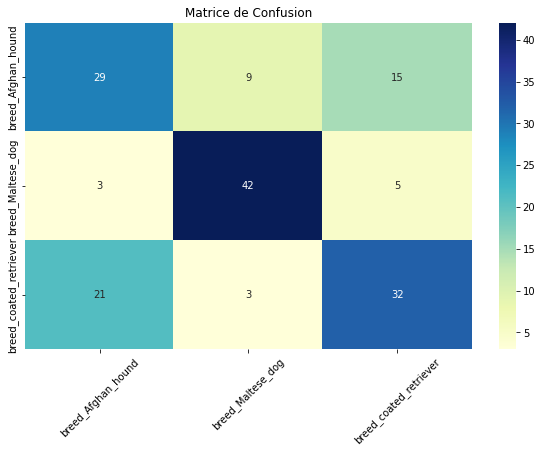

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Matrice de Confusion')
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu', xticklabels=final_model.classes_, yticklabels=final_model.classes_)
plt.show()

Dans la matrice de confusion, la diagonale correspond aux bonnes prédictions et les autres cases à des erreurs de prédiction. Dans notre cas, on obtient des résultats tout à fait honorables compte tenu du fait que l'on a utilisé que trois races de chien et que l'on n'a pas cherché à optimiser le modèle.</br>
Les trois races utilisées étant assez différentes les unes des autres, cela doit probablement faciliter la classification.</br>
Au niveau des sources d'erreurs, on a pu remarquer précédemment que sur certaines photos une personne apparaissait, ce qui pourrait fausser la prédiction. Pour palier ceci, il faudrait recadrer les photos pour ne voir que le chien.

# <a name="C16">Partie 5: Construction d'un réseau CNN</a>

Les réseaux de neurones convolutifs (CNN) sont spécialement conçus pour traiter des images en entrée. Leur avantage par rapport aux techniques d'apprentissage supervisé comme SIFT, est qu'ils réalisent automatiquement le travail d'extraction et de description des features.</br>
Leur architecture est composée de deux blocs principaux:
- un premier bloc qui agit comme extracteur de features
- un second bloc (commun à tous les réseaux de neurones) qui permet la classification

In [ ]:
def prepare_data_cnn(df, n_breeds):
  """Fonction qui prend en entrée le dataframe des images ainsi qu'un nombre de races, et renvoie les 
  données préparées pour le modèle CNN"""

  #On récupère les données correspondantes au nombre de races voulues
  top_breeds = list(data_grey['breed'].value_counts().index[:n_breeds])
  df = data_grey[data_grey.breed.isin(top_breeds)]
  df = df[['uri', 'breed']]

  #Séparation jeux entraînement/test
  train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
  #Séparation jeux entraînement/validation
  train, val = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

  #On redimensionne les images
  datagen = image.ImageDataGenerator(rescale=1./255)
  train_gen = datagen.flow_from_dataframe(train, 
                                          x_col='uri', 
                                          y_col='breed', 
                                          target_size=(224, 224),
                                          seed=42)
  test_gen = datagen.flow_from_dataframe(test, 
                                         x_col='uri', 
                                         y_col='breed', 
                                         target_size=(224, 224),
                                         seed=42)
  val_gen = datagen.flow_from_dataframe(val, 
                                        x_col='uri', 
                                        y_col='breed', 
                                        target_size=(224, 224),
                                        seed=42)
  
  return (train_gen, val_gen, test_gen)

In [ ]:
def get_cnn(n_breeds, activation_fun):
  """Fonction qui prend en entrée le nombre de races utilisée et renvoie le réseau cnn construit (mais non entraîné) """

  cnn = Sequential() 

  #Ajout de la première couche de convolution, suivie d'une couche ReLU
  cnn.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation=activation_fun))
  #Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
  cnn.add(Conv2D(64, (3, 3), padding='same', activation=activation_fun))
  #Ajout de la première couche de pooling
  cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  #On répète une seconde fois le bloc
  cnn.add(Conv2D(128, (3, 3), padding='same', activation=activation_fun))
  cnn.add(Conv2D(128, (3, 3), padding='same', activation=activation_fun))
  cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  #On répète une dernière fois le bloc
  cnn.add(Conv2D(256, (3, 3), padding='same', activation=activation_fun))
  cnn.add(Conv2D(256, (3, 3), padding='same', activation=activation_fun))
  cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  #Transformation des matrices en vecteurs
  cnn.add(GlobalAveragePooling2D())
  #Ajout d'une première couche fully-connected
  cnn.add(Dense(512, activation=activation_fun))
  #Ajout d'une seconde couche fully-connected
  cnn.add(Dense(n_breeds, activation='softmax'))

  return cnn

Pour limiter les temps de calculs on va dans un premier temps se limiter à trois races de chiens.

In [ ]:
train, val, test = prepare_data_cnn(data_grey, 3)

Found 508 validated image filenames belonging to 3 classes.
Found 159 validated image filenames belonging to 3 classes.
Found 127 validated image filenames belonging to 3 classes.


## <a name="C17">5.1: Fonction d'activation</a>

Un des hyperparamètres présent dans les layers du réseau de neurones et que l'on peut chercher à optimiser est la fonction d'activation, dont le rôle est de transformer de manière non linéaire les données et ainsi modifier spatialement leur représentation. On va tester trois fonctions différentes:
- **relu**
- **sigmoid**
- **tanh**

In [ ]:
def plot_activation_res(res):
  """Fonction qui prend en entrée un dictionnaire de modèles et renvoie les graphiques de comparaison
  des résultats obtenus"""

  #Extraction des résultats
  val_loss = {k:v.history['val_loss'] for k,v in res.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
  #Conversion en dataframe
  val_loss_curves = pd.DataFrame(val_loss)
  val_acc_curves = pd.DataFrame(val_acc)
  #Graphique
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  ax[0].plot(val_loss_curves.relu, label='relu')
  ax[0].plot(val_loss_curves.sigmoid, label='sigmoid')
  ax[0].plot(val_loss_curves.tanh, label='tanh')
  ax[0].set_title("Erreur en fonction de la fonction d'activation")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Erreur')
  ax[0].legend()

  ax[1].plot(val_acc_curves.relu, label='relu')
  ax[1].plot(val_acc_curves.sigmoid, label='sigmoid')
  ax[1].plot(val_acc_curves.tanh, label='tanh')
  ax[1].set_title("Accuracy en fonction de la fontion d'activation")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

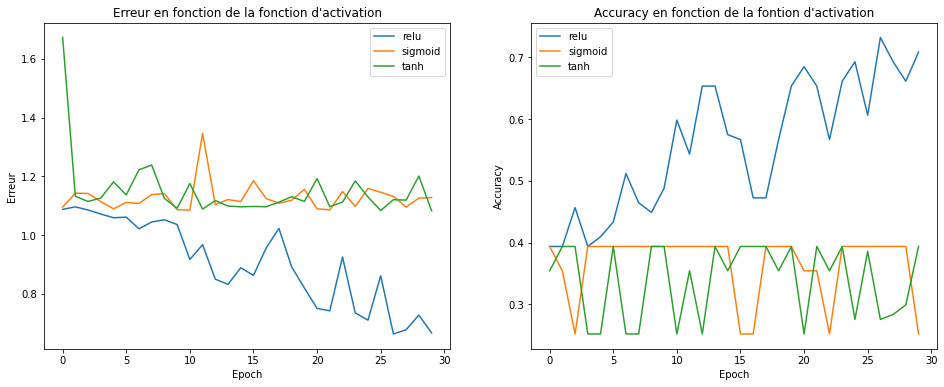

In [ ]:
activation_functions = ['relu', 'sigmoid', 'tanh']
res = {}

for activation_fun in activation_functions:
  #Création et entrainement du modèle
  cnn = get_cnn(3, activation_fun)
  cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=30, verbose=0)

  #On récupère le modèle
  res[activation_fun] = cnn_res


#Affichage des résultats
plot_activation_res(res)

Les résultats sont globalement meilleurs en utilisant pour fonction d'activation la fonction **relu**. Nous conserverons donc celle-ci pour la suite.

## <a name="C18">5.2: Fonction d'optimisation</a>

Au moment de compiler le réseau de neuronne, il faut préciser la fonction d'optimisation qui servira à optimiser les paramètres d'apprentissage pour obtenir le meilleur résultat. La plus utilisée est la descente de gradient, qui peut être implémentée de diverses façons. Testons les trois fonctions suivantes:
- **adam**
- **SGD**
- **adamax**

In [ ]:
def plot_optimizer_res(res):
  """Fonction qui prend en entrée un dictionnaire de modèles et renvoie les graphiques de comparaison
  des résultats obtenus"""

  #Extraction des résultats
  val_loss = {k:v.history['val_loss'] for k,v in res.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
  #Conversion en dataframe
  val_loss_curves = pd.DataFrame(val_loss)
  val_acc_curves = pd.DataFrame(val_acc)
  #Graphique
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  ax[0].plot(val_loss_curves.adam, label='adam')
  ax[0].plot(val_loss_curves.SGD, label='SGD')
  ax[0].plot(val_loss_curves.adamax, label='adamax')
  ax[0].set_title("Erreur en fonction de la fonction d'optimisation")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Erreur')
  ax[0].legend()

  ax[1].plot(val_acc_curves.adam, label='adam')
  ax[1].plot(val_acc_curves.SGD, label='SGD')
  ax[1].plot(val_acc_curves.adamax, label='adamax')
  ax[1].set_title("Accuracy en fonction de la fontion d'optimisation")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

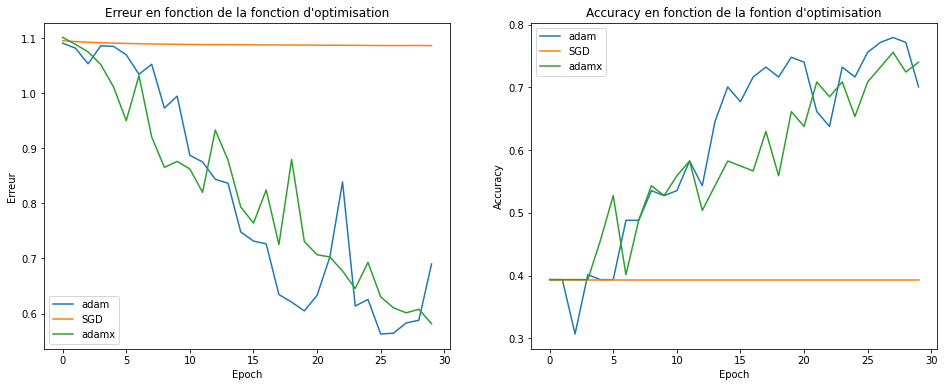

In [ ]:
optimizers = ['adam', 'SGD', 'adamax']
res = {}

for optimizer in optimizers:
  #Création et entrainement du modèle
  cnn = get_cnn(3, 'relu')
  cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=30, verbose=0)

  #On récupère le modèle
  res[optimizer] = cnn_res

plot_optimizer_res(res)

In [ ]:
res

{'SGD': <keras.callbacks.History at 0x7fd82a167450>,
 'adam': <keras.callbacks.History at 0x7fda0618ce50>,
 'adamax': <keras.callbacks.History at 0x7fd8216d5610>}

In [ ]:
res['adam'].history['accuracy'][-1]

0.7736220359802246

On obtient des résultats relativement similaires avec **adam** et **adamax**. Pour la suite, on conservera la fonction d'optimisation **adam**.

## <a name="C19">5.3: Epochs</a>

Un dernier hyperparamètre est le nombre de fois que l'on utilise le jeu de données pour entrainer le réseau de neurones. Ce nombre est choisi via l'hyperparamètre **epochs**. Testons différentes valeurs pour voir l'effet de cet hyperparamètre.

In [ ]:
def plot_epochs_res(res):
  """Fonction qui prend en entrée un dictionnaire de modèles et renvoie les graphiques de comparaison
  des résultats obtenus"""

  #Extraction des résultats
  val_loss = {k:v.history['val_loss'][-1] for k,v in res.items()}
  val_acc = {k:v.history['val_accuracy'][-1] for k,v in res.items()}
  #Conversion en dataframe
  val_loss_curves = pd.DataFrame([val_loss])
  val_acc_curves = pd.DataFrame([val_acc])
  #Graphique
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  ax[0].plot(val_loss_curves.columns, val_loss_curves.iloc[0,:], 'ro')
  ax[0].set_title("Erreur en fonction du nombre d'epochs")
  ax[0].set_xlabel("Nombre d'Epochs")
  ax[0].set_ylabel('Erreur')

  ax[1].plot(val_acc_curves.columns, val_acc_curves.iloc[0,:], 'ro')
  ax[1].set_title("Accuracy en fonction du nombre d'epochs")
  ax[1].set_xlabel("nombre d'Epochs")
  ax[1].set_ylabel('Accuracy')

  plt.show()

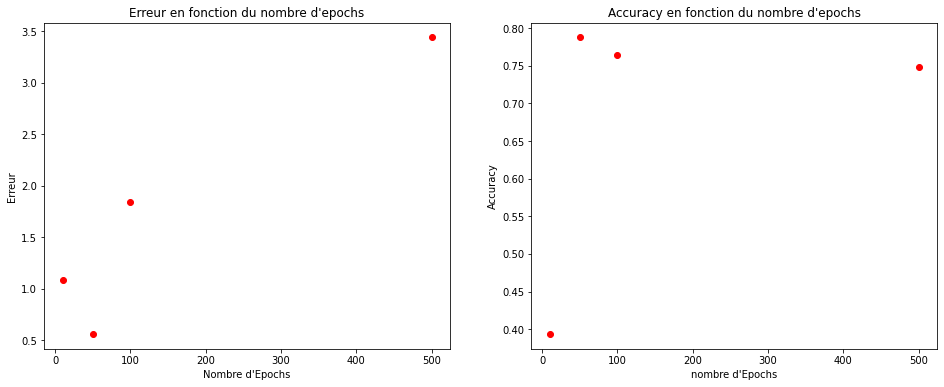

In [ ]:
epochs = [10, 50, 100, 500]
res = {}

for epoch in epochs:
  #Création et entrainement du modèle
  cnn = get_cnn(3, 'relu')
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=epoch, verbose=0)

  #On récupère le modèle
  res[epoch] = cnn_res

plot_epochs_res(res)

Les meilleurs résultats sont obtenus avec 50 epochs.

## <a name="C20">5.4: Classification d'images</a>

On peut à présent tester notre modèle CNN pour notre problématique de classification d'images. On va tout d'abord n'utiliser que 3 races de chiens avant d'essayer d'augmenter un peu ce nombre.

In [ ]:
def plot_confusion_matrix(model, test, n_breeds):
  """Fonction qui prend en entrée le modèle utilisé (et entraîné), le jeu de test ainsi que le nombre de classes
  cherchées et renvoie la matrice de confusion du jeu test"""

  pred = np.argmax(model.predict(test),axis=1)
  cf_matrix = confusion_matrix(test.classes, pred)
  plt.figure(figsize=(10,6))
  sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
  plt.title('Matrice de confusion')
  plt.axis('off')
  plt.show()

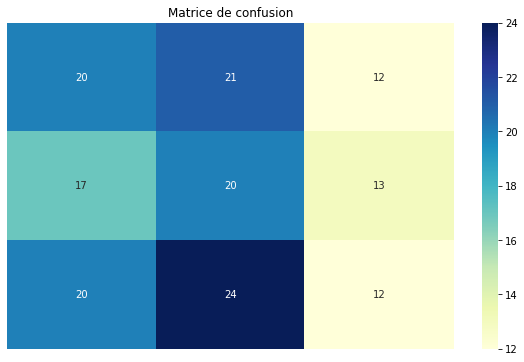

In [ ]:
#Définition et entrainement du modèle
cnn = get_cnn(3, 'relu')
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_res = cnn.fit(train, validation_data=val, epochs=50, verbose=0)

#Prédiction sur le jeu test
plot_confusion_matrix(cnn, test, 3)

In [ ]:
cnn.evaluate(test)

5/5 [==============================] - 1s 122ms/step - loss: 0.6117 - accuracy: 0.6918


[0.6117358207702637, 0.6918238997459412]

Found 2784 validated image filenames belonging to 20 classes.
Found 871 validated image filenames belonging to 20 classes.
Found 696 validated image filenames belonging to 20 classes.


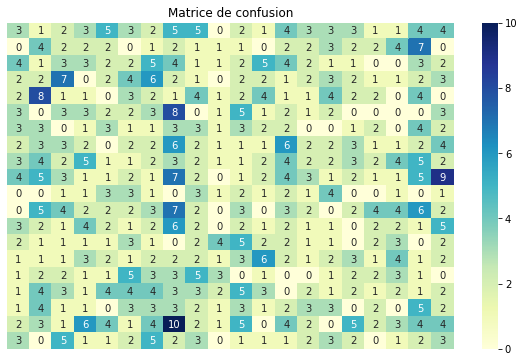

In [ ]:
#Préparation des données
train, val, test = prepare_data_cnn(data_grey, 20)

#Définition et entrainement du modèle
cnn = get_cnn(20, 'relu')
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_res = cnn.fit(train, validation_data=val, epochs=50, verbose=0)

#Prédiction sur le jeu test
plot_confusion_matrix(cnn, test, 20)

In [ ]:
cnn.evaluate(test)

28/28 [==============================] - 3s 100ms/step - loss: 5.9329 - accuracy: 0.2836


[5.932945251464844, 0.28358209133148193]

Les résultats sont assez moyens et deviennent mauvais lorsqu'on augmente le nombre de races utilisées. Pour obtenir un modèle plus robuste, il faudrait augmenter le nombre de layers mais surtout utiliser un nombre d'images beaucoup plus grand, mais cela ferait exploser le temps de calcul...

# <a name="C21">Partie 6: CNN et transfer learning</a>

Entraîner un réseau de neurones convolutif est très coûteux : plus les couches s'empilent, plus le nombre de convolutions et de paramètres à optimiser est élevé. L'ordinateur doit être en mesure de stocker plusieurs gigaoctets de données et de faire efficacement les calculs. Pour y remédier, on fait appel au Transfer Learning (ou apprentissage par transfert).  Le principe est d'utiliser les connaissances acquises par un réseau de neurones lors de la résolution d'un problème afin d'en résoudre un autre plus ou moins similaire. On réalise ainsi un transfert de connaissances, d'où le nom.

Pour mettre en place le transfer learning dans notre cas d'étude, nous allons utiliser trois réseaux pré-entraînés que nous comparerons:
- VGG16: CNN très populaire développé en 2014 à l'aide de la base d'images ImageNet recceuillant plus de 14 millions d'images labellisées et réparties dans plus de 1000 classes
- ResNet50: CNN dans lequel les fonctions résiduelles sont apprises en tenant compte des entrées des couches précédentes
- Xception: CNN dans lequel plusieurs transformations sont testées au niveau d'une chouche, le réseau choisissant ensuite celle qui donne les meilleurs résultats.

Dans un premier temps, pour tester et expérimenter les différents modèles, nous nous limiterons à 15 races afin de réduire les temps d'exécution.

In [ ]:
#Préparation des données
nb_breeds = 15
train, val, test = prepare_data_cnn(data_grey, nb_breeds)

Found 2147 validated image filenames belonging to 15 classes.
Found 671 validated image filenames belonging to 15 classes.
Found 537 validated image filenames belonging to 15 classes.


In [ ]:
#Fonction d'affichage pour la comparaison
def plot_tfl_res(res):
  """Fonction qui prend en entrée un dictionnaire de modèles et renvoie les graphiques de comparaison
  des résultats obtenus"""
  #Extraction des résultats
  val_loss = {k:v.history['val_loss'] for k,v in res.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
  #Conversion en dataframe
  val_loss_curves = pd.DataFrame(val_loss)
  val_acc_curves = pd.DataFrame(val_acc)
  #Graphique
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  ax[0].plot(val_loss_curves.VGG16, label='VGG16')
  ax[0].plot(val_loss_curves.ResNet50, label='ResNet50')
  ax[0].plot(val_loss_curves.Xception, label='Xception')
  ax[0].set_title("Erreur en fonction du modèle utilisé")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Erreur')
  ax[0].legend()

  ax[1].plot(val_acc_curves.VGG16, label='VGG16')
  ax[1].plot(val_acc_curves.ResNet50, label='ResNet50')
  ax[1].plot(val_acc_curves.Xception, label='Xception')
  ax[1].set_title("Accuracy en fonction du modèle utilisé")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

## <a name="C22">6.1: Fine-tuning total</a>

La première stratégie de transfer learning correspond à remplacer la dernière couche fully-connected et à ré-entraîner toutes les autres couches sur les nouvelles images. 

In [ ]:
def cnn_ft_total(model_name, nb_breeds):
  """Fonction qui prend en entrée le nom du modèle que l'on veut utiliser ainsi que le nombre de races utilisées
  et renvoie le modèle prêt pour le transfer learning avec fine-tuning total"""

  #Charger le modèle pré-entraîné sans les couches fully-connected
  if model_name == 'VGG16':
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'ResNet50':
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else:
    model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  #Entraîner toutes les couches
  for layer in model.layers:
    layer.trainable = True

  #Définir le nouveau modèle
  new_model = Sequential()
  new_model.add(model)
  new_model.add(GlobalAveragePooling2D())
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dense(nb_breeds, activation='softmax'))

  return new_model

In [ ]:
#Tableau de comparaison
df_ft_total = pd.DataFrame([], index=['VGG16', 'ResNet50', 'Xception'], 
                           columns=['Temps entraînement', 'accuracy train', 'accuracy val', 'accuracy test'])
df_ft_total

Temps entraînement accuracy train accuracy val accuracy test
VGG16                   NaN            NaN          NaN           NaN
ResNet50                NaN            NaN          NaN           NaN
Xception                NaN            NaN          NaN           NaN

21/21 [==============================] - 4s 196ms/step - loss: 1.6105 - accuracy: 0.6990


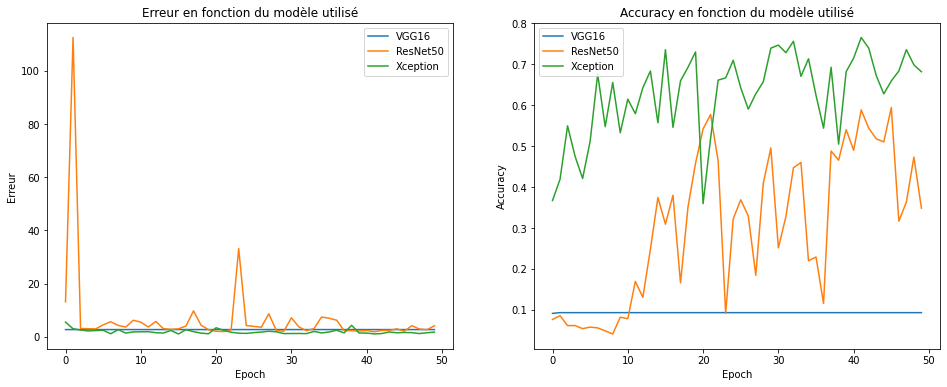

In [ ]:
model_names = ['VGG16', 'ResNet50', 'Xception']
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_ft_total(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=50, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_ft_total.loc[model_name, 'Temps entraînement'] = time
  df_ft_total.loc[model_name, 'accuracy train'] = cnn_res.history['accuracy'][-1]
  df_ft_total.loc[model_name, 'accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_ft_total.loc[model_name, 'accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

plot_tfl_res(res)

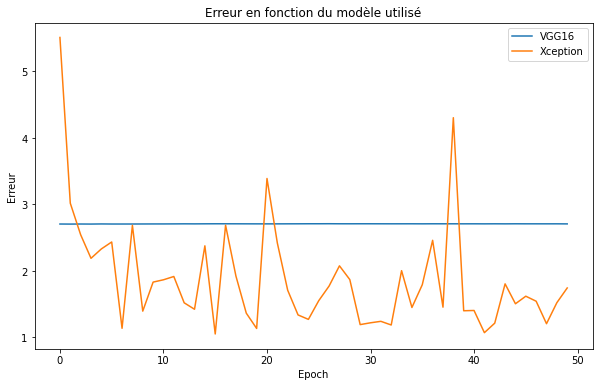

In [ ]:
#Extraction des résultats
val_loss = {k:v.history['val_loss'] for k,v in res.items()}
#Conversion en dataframe
val_loss_curves = pd.DataFrame(val_loss)

plt.figure(figsize=(10, 6))
plt.plot(val_loss_curves.VGG16, label='VGG16')
plt.plot(val_loss_curves.Xception, label='Xception')
plt.title("Erreur en fonction du modèle utilisé")
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.show()

In [ ]:
df_ft_total

Temps entraînement accuracy train accuracy val accuracy test
VGG16           2219.843451       0.089427      0.09311      0.090909
ResNet50        1280.664394       0.990685     0.348231      0.329359
Xception        2256.764077       0.990685     0.681564      0.698957

Cette méthode est plus intéressante quand le jeu de données est grand, ce qui n'est pas le cas ici. De plus, ré-entrainer toutes les couches a pour conséquence un temps de calcul plus élevé.

Résultats du modèle VGG16

21/21 [==============================] - 4s 161ms/step - loss: 2.7075 - accuracy: 0.0909



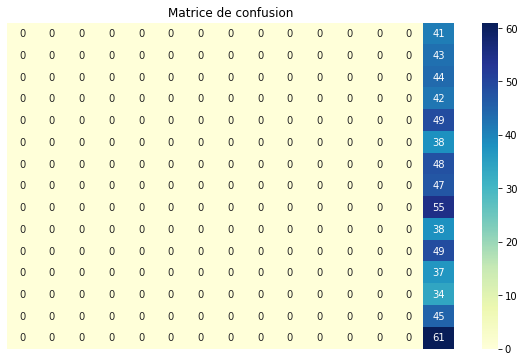


#########################################################################################################################

Résultats du modèle ResNet50

21/21 [==============================] - 2s 113ms/step - loss: 4.1071 - accuracy: 0.3294



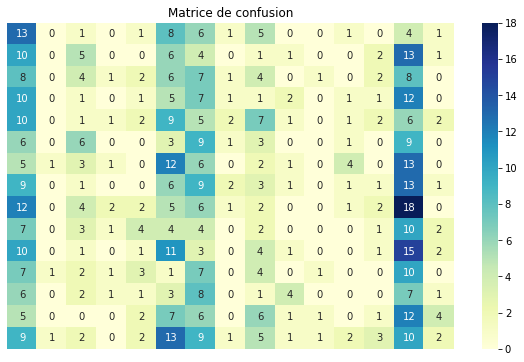


#########################################################################################################################

Résultats du modèle Xception

21/21 [==============================] - 3s 147ms/step - loss: 1.6105 - accuracy: 0.6990



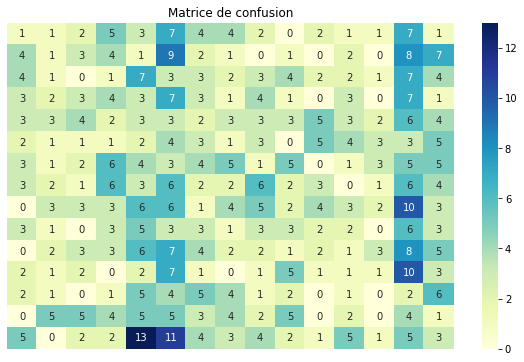


#########################################################################################################################



In [ ]:
for name, model in model_dict.items():
  print("Résultats du modèle " + name)
  print('')
  model.evaluate(test)
  print('')
  plot_confusion_matrix(model, test, nb_breeds)
  print('')
  print('#########################################################################################################################')
  print('')

## <a name="C23">6.2: Extraction de features</a>

Cette seconde stratégie consiste à se servir des features du réseau pré-entraîné pour représenter les images du nouveau problème. Pour cela, on retire la dernière couche fully-connected et on fixe tous les autres paramètres.

In [ ]:
def cnn_features_extraction(model_name, nb_breeds):
  """Fonction qui prend en entrée le nom du modèle que l'on veut utiliser ainsi que le nombre de races utilisées
  et renvoie le modèle prêt pour le transfer learning avec extraction de features"""

  #Charger le modèle pré-entraîné sans les couches fully-connected
  if model_name == 'VGG16':
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'ResNet50':
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else:
    model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  #Entraîner aucune couche
  for layer in model.layers:
    layer.trainable = False

  #Définir le nouveau modèle
  new_model = Sequential()
  new_model.add(model)
  new_model.add(GlobalAveragePooling2D())
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dense(nb_breeds, activation='softmax'))

  return new_model

In [ ]:
#Tableau de comparaison
df_features_extraction = pd.DataFrame([], index=['VGG16', 'ResNet50', 'Xception'], 
                                      columns=['Temps entraînement', 'accuracy train', 'accuracy val', 'accuracy test'])
df_features_extraction

Temps entraînement accuracy train accuracy val accuracy test
VGG16                   NaN            NaN          NaN           NaN
ResNet50                NaN            NaN          NaN           NaN
Xception                NaN            NaN          NaN           NaN

21/21 [==============================] - 3s 139ms/step - loss: 0.7590 - accuracy: 0.8689


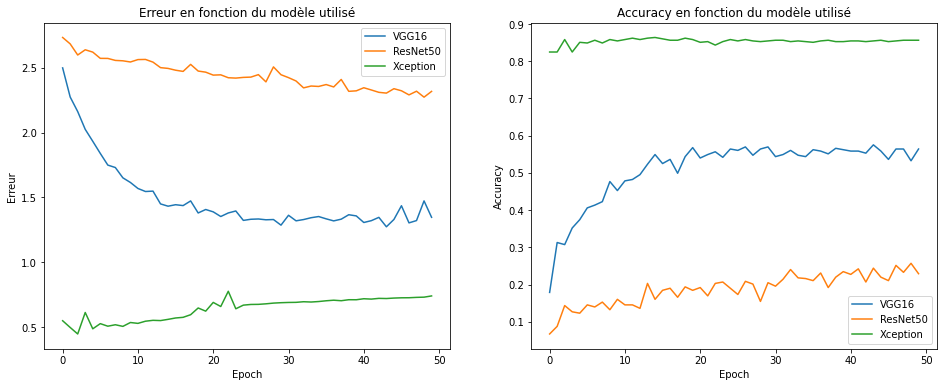

In [ ]:
model_names = ['VGG16', 'ResNet50', 'Xception']
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_features_extraction(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=50, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_features_extraction.loc[model_name, 'Temps entraînement'] = time
  df_features_extraction.loc[model_name, 'accuracy train'] = cnn_res.history['accuracy'][-1]
  df_features_extraction.loc[model_name, 'accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_features_extraction.loc[model_name, 'accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

plot_tfl_res(res)

In [ ]:
df_features_extraction

Temps entraînement accuracy train accuracy val accuracy test
VGG16            707.992833       0.796926     0.564246      0.543964
ResNet50         460.273884       0.237541      0.22905      0.213115
Xception          592.40372            1.0     0.856611      0.868852

Cette méthode, intéressante quand les données sont similaires à celles utilisées pour l'entraînement du modèle, réduit grandement le temps de calcul donne des résultats intéressants pour le modèle **Xception**.

Résultats du modèle VGG16

21/21 [==============================] - 4s 164ms/step - loss: 1.4668 - accuracy: 0.5440



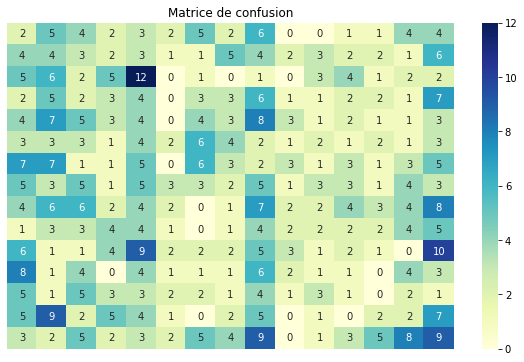


#########################################################################################################################

Résultats du modèle ResNet50

21/21 [==============================] - 2s 108ms/step - loss: 2.3818 - accuracy: 0.2131



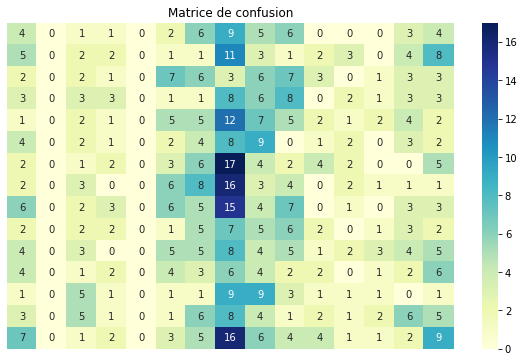


#########################################################################################################################

Résultats du modèle Xception

21/21 [==============================] - 3s 139ms/step - loss: 0.7590 - accuracy: 0.8689



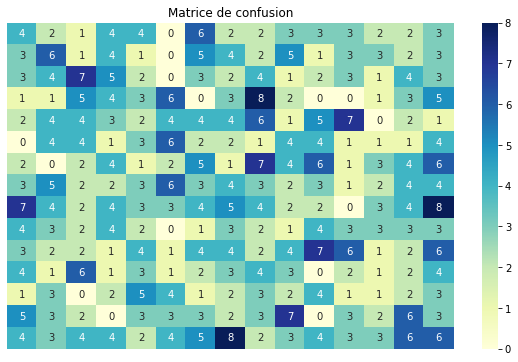


#########################################################################################################################



In [ ]:
for name, model in model_dict.items():
  print("Résultats du modèle " + name)
  print('')
  model.evaluate(test)
  print('')
  plot_confusion_matrix(model, test, nb_breeds)
  print('')
  print('#########################################################################################################################')
  print('')

## <a name="C24">6.3: Fine-tuning partiel</a>

Il s'agit d'un mélange des deux premières stratégies : on remplace à nouveau la dernière couche fully-connected et on fixe les paramètres de certaines couches du réseau pré-entraîné. Ainsi, en plus du classifieur, on entraîne sur les nouvelles images les couches non-fixées, qui correspondent en général aux plus hautes du réseau.</br>
Nous allons ici ré-entrainer 10% des couches convolutionnelles hautes.

In [ ]:
def cnn_ft_partiel(model_name, nb_breeds):
  """Fonction qui prend en entrée le nom du modèle que l'on veut utiliser ainsi que le nombre de races utilisées
  et renvoie le modèle prêt pour le transfer learning avec fine-tuning partiel"""

  #Charger le modèle pré-entraîné sans les couches fully-connected
  if model_name == 'VGG16':
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'ResNet50':
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else:
    model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  #Entraîner 10% des couches hautes
  nb_10 = int(len(model.layers)*0.9)
  for layer in model.layers[:nb_10]:
    layer.trainable = False
  for layer in model.layers[nb_10:]:
    layer.trainable = True

  #Définir le nouveau modèle
  new_model = Sequential()
  new_model.add(model)
  new_model.add(GlobalAveragePooling2D())
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dense(nb_breeds, activation='softmax'))

  return new_model

In [ ]:
#Tableau de comparaison
df_ft_partiel = pd.DataFrame([], index=['VGG16', 'ResNet50', 'Xception'], 
                             columns=['Temps entraînement', 'accuracy train', 'accuracy val', 'accuracy test'])
df_ft_partiel

Temps entraînement accuracy train accuracy val accuracy test
VGG16                   NaN            NaN          NaN           NaN
ResNet50                NaN            NaN          NaN           NaN
Xception                NaN            NaN          NaN           NaN

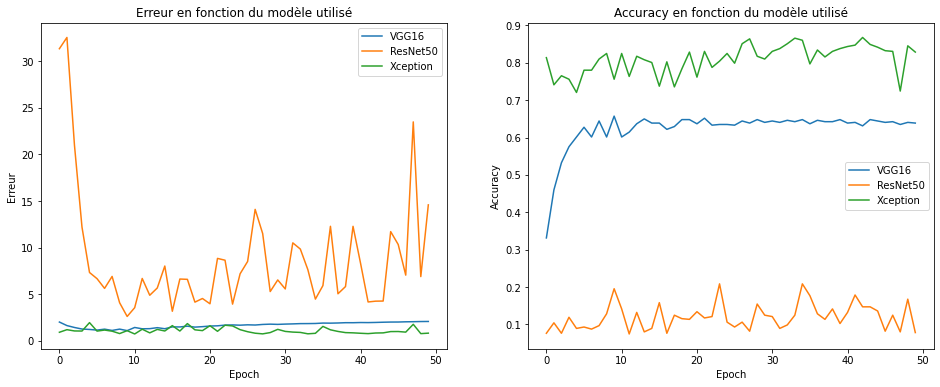

In [ ]:
model_names = ['VGG16', 'ResNet50', 'Xception']
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_ft_partiel(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=50, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_ft_partiel.loc[model_name, 'Temps entraînement'] = time
  df_ft_partiel.loc[model_name, 'accuracy train'] = cnn_res.history['accuracy'][-1]
  df_ft_partiel.loc[model_name, 'accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_ft_partiel.loc[model_name, 'accuracy test'] = cnn.evaluate(test)[1]


  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

plot_tfl_res(res)

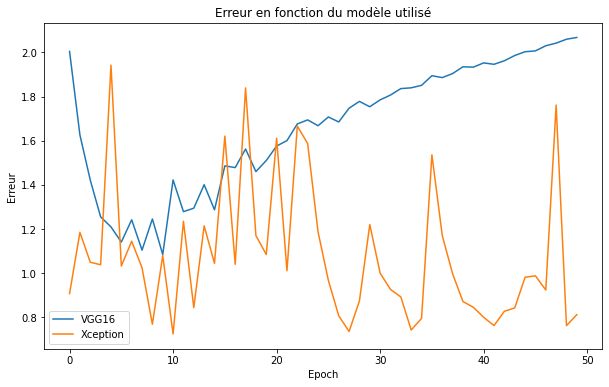

In [ ]:
#Extraction des résultats
val_loss = {k:v.history['val_loss'] for k,v in res.items()}
#Conversion en dataframe
val_loss_curves = pd.DataFrame(val_loss)

plt.figure(figsize=(10, 6))
plt.plot(val_loss_curves.VGG16, label='VGG16')
plt.plot(val_loss_curves.Xception, label='Xception')
plt.title("Erreur en fonction du modèle utilisé")
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.show()

In [ ]:
df_ft_partiel

Temps entraînement accuracy train accuracy val accuracy test
VGG16           1379.809457            1.0     0.638734      0.661699
ResNet50         513.711118       0.746157     0.078212      0.117735
Xception         742.636825       0.993945     0.828678      0.862891

Pour le modèle **Xception**, le fine-tuning partiel semble être une option intéressante. La méthode d'extraction de données donnait déjà de bons résultats mais il ne faut pas oublier que l'on s'est limité à 15 races et que les couches convolutionnelles hautes permettent la détection de features précises et caractéristiques d'où l'idée de les ré-entraîner sur nos images. C'est donc ce modèle et cette méthode que nous allons retenir.

Résultats du modèle VGG16

21/21 [==============================] - 4s 161ms/step - loss: 1.8429 - accuracy: 0.6617



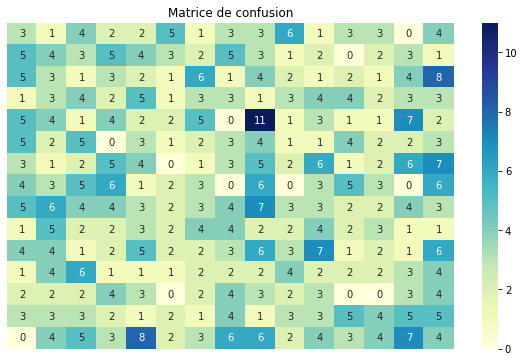


#########################################################################################################################

Résultats du modèle ResNet50

21/21 [==============================] - 3s 114ms/step - loss: 13.4468 - accuracy: 0.1177



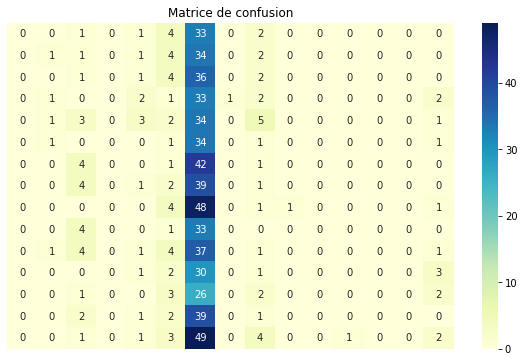


#########################################################################################################################

Résultats du modèle Xception

21/21 [==============================] - 3s 135ms/step - loss: 0.7334 - accuracy: 0.8629



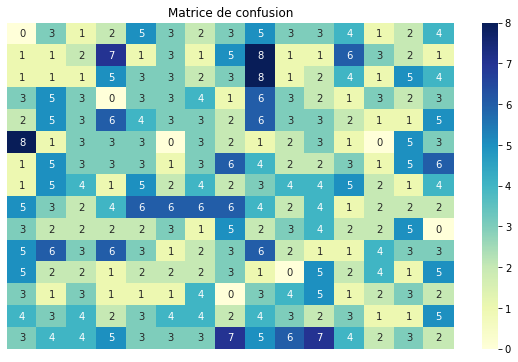


#########################################################################################################################



In [ ]:
for name, model in model_dict.items():
  print("Résultats du modèle " + name)
  print('')
  model.evaluate(test)
  print('')
  plot_confusion_matrix(model, test, nb_breeds)
  print('')
  print('#########################################################################################################################')
  print('')

## <a name="C25">6.4: Apports de la Data Augmentation</a>
Notre jeu de données étant limité, et même si le transfer learning par  fine-tuning est adapté à de petits jeux de données, il peut intéressant d'évaluer l'apport de la data augmentation sur les résultats du modèle. On rapelle que la data augmentation permet d'étoffer le jeu d'images en créant des variations d'une même image.

In [ ]:
def prepare_data_aug_cnn(df, n_breeds):
  """Fonction qui prend en entrée le dataframe des images ainsi qu'un nombre de races, et renvoie les 
  données préparées pour le modèle CNN avec data augmentation"""

  #On récupère les données correspondantes au nombre de races voulues
  top_breeds = list(data_grey['breed'].value_counts().index[:n_breeds])
  df = data_grey[data_grey.breed.isin(top_breeds)]
  df = df[['uri', 'breed']]

  #Séparation jeux entraînement/test
  train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
  #Séparation jeux entraînement/validation
  train, val = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

  #On redimensionne les images
  datagen = image.ImageDataGenerator(rescale=1./255)
  datagen_aug = image.ImageDataGenerator(rescale=1./255, 
                                         rotation_range=10,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         shear_range=0.2,
                                         brightness_range=[0.2,1.2], 
                                         fill_mode="nearest")
  
  train_gen = datagen.flow_from_dataframe(train, 
                                          x_col='uri', 
                                          y_col='breed', 
                                          target_size=(224, 224),
                                          seed=42)

  train_gen_aug = datagen_aug.flow_from_dataframe(train,
                                                  x_col='uri', 
                                                  y_col='breed', 
                                                  target_size=(224, 224),
                                                  seed=42)
  test_gen = datagen.flow_from_dataframe(test, 
                                         x_col='uri', 
                                         y_col='breed', 
                                         target_size=(224, 224),
                                         seed=42)
  val_gen = datagen.flow_from_dataframe(val, 
                                        x_col='uri', 
                                        y_col='breed', 
                                        target_size=(224, 224),
                                        seed=42)
  
  return (train_gen, train_gen_aug, val_gen, test_gen)

In [ ]:
#Fonction d'affichage pour la comparaison
def plot_aug_res(res):
  """Fonction qui prend en entrée un dictionnaire de modèles et renvoie les graphiques de comparaison
  des résultats obtenus"""
  #Extraction des résultats
  val_loss = {k:v.history['val_loss'] for k,v in res.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
  #Conversion en dataframe
  val_loss_curves = pd.DataFrame(val_loss)
  val_acc_curves = pd.DataFrame(val_acc)
  #Graphique
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  ax[0].plot(val_loss_curves.sans_aug, label='Sans Data Augmentation')
  ax[0].plot(val_loss_curves.avec_aug, label='Avec Data Augmentation')
  ax[0].set_title("Erreur en fonction du modèle utilisé")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Erreur')
  ax[0].legend()

  ax[1].plot(val_acc_curves.sans_aug, label='Sans Data Augmentation')
  ax[1].plot(val_acc_curves.avec_aug, label='Avec Data Augmentation')
  ax[1].set_title("Accuracy en fonction du modèle utilisé")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

In [ ]:
#Préparation des données avec augmentation
nb_breeds = 15
train, train_aug, val, test = prepare_data_aug_cnn(data_grey, nb_breeds)

Found 2147 validated image filenames belonging to 15 classes.
Found 2147 validated image filenames belonging to 15 classes.
Found 671 validated image filenames belonging to 15 classes.
Found 537 validated image filenames belonging to 15 classes.


In [ ]:
#Tableau de comparaison
df_aug = pd.DataFrame([], index=['sans_aug', 'avec_aug'], 
                      columns=['Temps entraînement', 'accuracy train', 'accuracy val', 'accuracy test'])
df_aug

Temps entraînement accuracy train accuracy val accuracy test
sans_aug                NaN            NaN          NaN           NaN
avec_aug                NaN            NaN          NaN           NaN

21/21 [==============================] - 3s 136ms/step - loss: 0.7807 - accuracy: 0.8420


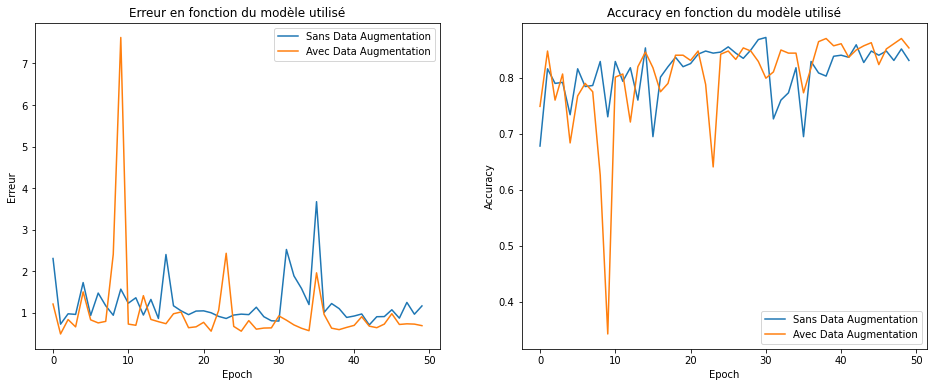

In [ ]:
#Comparaison des modèles
model_name = 'Xception'
models = ['sans_aug', 'avec_aug']
res = {}
model_dict = {}

for model in models:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_ft_partiel(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  if model == 'sans_aug':
    cnn_res = cnn.fit(train, validation_data=val, epochs=50, verbose=0)
  else:
    cnn_res = cnn.fit(train_aug, validation_data=val, epochs=50, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_aug.loc[model, 'Temps entraînement'] = time
  df_aug.loc[model, 'accuracy train'] = cnn_res.history['accuracy'][-1]
  df_aug.loc[model, 'accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_aug.loc[model, 'accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model] = cnn_res
  model_dict[model] = cnn

plot_aug_res(res)

In [ ]:
df_aug

Temps entraînement accuracy train accuracy val accuracy test
sans_aug        1065.172253       0.994877      0.83054      0.842027
avec_aug        1759.607965       0.978575     0.852886      0.842027

Dans la limite de 15 races, la data augmentation ne produit pas de résultats significativement meilleurs. Toutefois, c'est une méthode intéressante pour limiter le sur-apprentissage et nous l'utiliserons pour entraîner notre modèle sur l'ensemble du jeu de données.

Résultats du modèle Xception sans_aug

21/21 [==============================] - 3s 138ms/step - loss: 1.2016 - accuracy: 0.8420



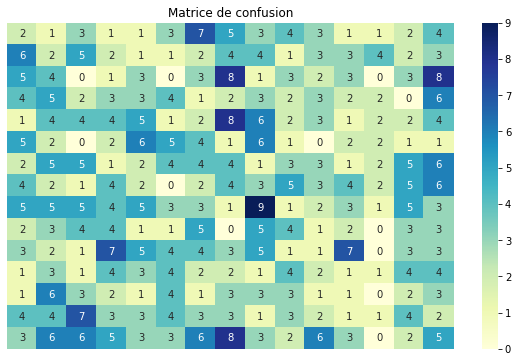


#########################################################################################################################

Résultats du modèle Xception avec_aug

21/21 [==============================] - 3s 138ms/step - loss: 0.7807 - accuracy: 0.8420



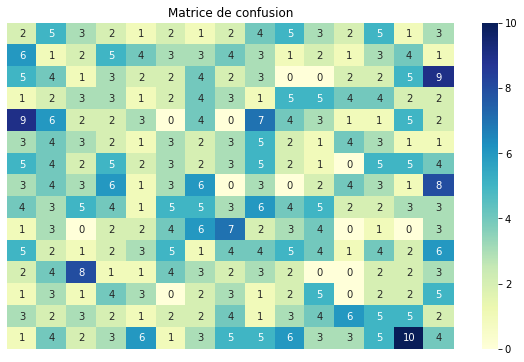


#########################################################################################################################



In [ ]:
for name, model in model_dict.items():
  print("Résultats du modèle Xception " + name)
  print('')
  model.evaluate(test)
  print('')
  plot_confusion_matrix(model, test, nb_breeds)
  print('')
  print('#########################################################################################################################')
  print('')